In [1]:
# Cell 1: Install Dependencies & Environment Setup
# ==================================================================================
import sys
import os
from datetime import datetime

print(f"[{datetime.now().strftime('%H:%M:%S')}] 🚀 STARTING ENVIRONMENT SETUP...")

# 1. Fix Protobuf for Tensorboard/WandB compatibility
# # This fixes the 'MessageFactory' AttributeError you saw earlier
# print(f"[{datetime.now().strftime('%H:%M:%S')}] 🔧 Fixing Protobuf compatibility...")
# !pip install "protobuf<=3.20.3" --force-reinstall --quiet

# 2. Install Segmentation Models & MONAI
print(f"[{datetime.now().strftime('%H:%M:%S')}] 📦 Installing Segmentation Models PyTorch & MONAI...")
!pip install -U segmentation-models-pytorch monai --quiet

import torch
import monai
import segmentation_models_pytorch as smp
import warnings
warnings.filterwarnings("ignore")

print("\n" + "="*50)
print("✅ ENVIRONMENT CHECK")
print("="*50)

# Check GPU
if torch.cuda.is_available():
    print(f"✅ GPU DETECTED: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
else:
    print("❌ NO GPU DETECTED. Training will likely fail or be impossible.")

print(f"✅ PyTorch Version: {torch.__version__}")
print(f"✅ MONAI Version:   {monai.__version__}")
print(f"✅ SMP Version:     {smp.__version__}")
print(f"[{datetime.now().strftime('%H:%M:%S')}] 🏁 Setup Complete.")

[10:23:11] 🚀 STARTING ENVIRONMENT SETUP...
[10:23:11] 📦 Installing Segmentation Models PyTorch & MONAI...


<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-11-23 10:23:22.906421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763893402.929225    1257 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763893402.936178    1257 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 


✅ ENVIRONMENT CHECK
✅ GPU DETECTED: Tesla T4
   VRAM: 15.83 GB
   CUDA Version: 12.4
✅ PyTorch Version: 2.6.0+cu124
✅ MONAI Version:   1.5.1
✅ SMP Version:     0.5.0
[10:23:31] 🏁 Setup Complete.


In [2]:
# Cell 2: Configuration & Seeding
# ==================================================================================
import torch
import numpy as np
import random
import os

print("⚙️ LOADING CONFIGURATION...")

# --- CONFIGURATION ---
CONFIG = {
    # --- COMPUTUTE ---
    "SEED": 42,
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    
    # --- DATA & ARCHITECTURE ---
    "IMG_SIZE": 256,            # CHANGED: 224 matches the 'tu-maxvit...224' encoder
    "MODEL_NAME": "DeepLabV3Plus",       
    "ENCODER": "resnet50", 
    "ENCODER_WEIGHTS": "imagenet",
    "IN_CHANNELS": 3,           # 2.5D Stack (Prev, Curr, Next)
    
    # --- TRAINING STRATEGY ---
    "BATCH_SIZE": 128,           
    "ACCUMULATE_GRAD": 1,       # Increase this if you run out of VRAM (e.g., set to 2 or 4)
    "EPOCHS": 20,               
    "LR": 3e-4,                 
    "MIN_LR": 1e-6,             
    "WEIGHT_DECAY": 1e-2,       
    
    # --- PATHS ---
    "DATA_PATH": "/kaggle/input/radium-standard-dataset/PROCESSED_DATASET_FREESURFER", 
    "CSV_PATH":  "/kaggle/input/radium-standard-dataset/PROCESSED_DATASET_FREESURFER/metadata.csv",
    
    # --- CROSS VALIDATION ---
    "TEST_SPLIT": 0.02,         # 10% for Holdout Testing
    "N_FOLDS": 5,               # Cross-val on the remaining 90%
    "FOLDS_TO_RUN": [0],        # Only running Fold 0 for now
    
    # --- LOGGING ---
    "PROJECT_NAME": "SUPER_ULTRA_RADIUM",
    "ENTITY": "alzhemer_segmentaion"
}

def seed_everything(seed=42):
    print(f"🌱 Seeding environment with SEED: {seed}...")
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # FALSE ensures reproducibility, TRUE is faster
    print("   -> Seeding complete.")

seed_everything(CONFIG['SEED'])

print("\n" + "="*30)
print("📋 CONFIGURATION STATUS")
print("="*30)
print(f"✅ Device:       {CONFIG['DEVICE']}")
print(f"✅ Image Size:   {CONFIG['IMG_SIZE']}x{CONFIG['IMG_SIZE']}")
print(f"✅ Encoder:      {CONFIG['ENCODER']}")
print(f"✅ Batch Size:   {CONFIG['BATCH_SIZE']}")
print(f"✅ Dataset Path: {CONFIG['DATA_PATH']}")

⚙️ LOADING CONFIGURATION...
🌱 Seeding environment with SEED: 42...
   -> Seeding complete.

📋 CONFIGURATION STATUS
✅ Device:       cuda
✅ Image Size:   256x256
✅ Encoder:      resnet50
✅ Batch Size:   128
✅ Dataset Path: /kaggle/input/radium-standard-dataset/PROCESSED_DATASET_FREESURFER


In [3]:
# Cell 3: Data Preparation & Splitting
# ==================================================================================
import pandas as pd
import re
from sklearn.model_selection import GroupKFold, train_test_split

def prepare_data(csv_path):
    print("\n" + "="*50)
    print("📊 DATA PREPARATION START")
    print("="*50)
    
    # 1. Load CSV
    print(f"📂 Loading metadata from: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"   -> Raw CSV loaded. Rows: {len(df)}")
    
    # 2. Extract Slice Number (Robust Regex)
    print("🔢 Extracting slice numbers...")
    def extract_slice(x):
        # Looks for 'slice_' followed by digits
        match = re.search(r'slice_(\d+)', x)
        return int(match.group(1)) if match else 0
        
    df['slice_num'] = df['image_id'].apply(extract_slice)
    
    # 3. Sort (Patient -> Slice)
    # This is CRITICAL for 2.5D to work. We must sort by patient, then by slice index.
    print("...Sorting dataframe by Patient and Slice Number...")
    df = df.sort_values(by=['patient', 'slice_num']).reset_index(drop=True)
    
    # 4. 2.5D Logic (Shift)
    print("📚 Generating 2.5D Context (Previous/Next Slices)...")
    # Shift +1 gets the previous slice, Shift -1 gets the next slice
    df['prev_image_id'] = df.groupby('patient')['image_id'].shift(1)
    df['next_image_id'] = df.groupby('patient')['image_id'].shift(-1)
    
    # Handle edge cases: The first slice has no 'prev', the last slice has no 'next'.
    # We fill these with the current image (duplication) to avoid crashes.
    df['prev_image_id'] = df['prev_image_id'].fillna(df['image_id'])
    df['next_image_id'] = df['next_image_id'].fillna(df['image_id'])
    
    # SANITY CHECK PRINT
    print("\n   👀 SANITY CHECK (First 2 rows):")
    print(df[['patient', 'slice_num', 'prev_image_id', 'image_id', 'next_image_id']].head(2))
    print("   -> Logic looks correct if image_ids follow sequence.\n")
    
    # 5. SPLITTING (Patient Aware)
    print("✂️ performing Train/Test Split...")
    unique_patients = df['patient'].unique()
    print(f"   -> Found {len(unique_patients)} unique patients.")
    
    train_patients, test_patients = train_test_split(
        unique_patients, 
        test_size=CONFIG['TEST_SPLIT'], 
        random_state=CONFIG['SEED']
    )
    
    train_val_df = df[df['patient'].isin(train_patients)].reset_index(drop=True)
    test_df = df[df['patient'].isin(test_patients)].reset_index(drop=True)
    
    print(f"\n✅ DATASET STATISTICS:")
    print(f"   -------------------")
    print(f"   Total Patients:   {len(unique_patients)}")
    print(f"   TRAIN/VAL POOL:   {len(train_patients)} Patients | {len(train_val_df)} Images")
    print(f"   TEST HOLDOUT:     {len(test_patients)} Patients | {len(test_df)} Images")
    
    return train_val_df, test_df

# Run the function
train_val_df, test_df = prepare_data(CONFIG['CSV_PATH'])


📊 DATA PREPARATION START
📂 Loading metadata from: /kaggle/input/radium-standard-dataset/PROCESSED_DATASET_FREESURFER/metadata.csv
   -> Raw CSV loaded. Rows: 15788
🔢 Extracting slice numbers...
...Sorting dataframe by Patient and Slice Number...
📚 Generating 2.5D Context (Previous/Next Slices)...

   👀 SANITY CHECK (First 2 rows):
      patient  slice_num                                   prev_image_id  \
0  002_S_0295         29  002_S_0295_2006-04-18_08_20_30.0_slice_029.png   
1  002_S_0295         30  002_S_0295_2006-04-18_08_20_30.0_slice_029.png   

                                         image_id  \
0  002_S_0295_2006-04-18_08_20_30.0_slice_029.png   
1  002_S_0295_2006-04-18_08_20_30.0_slice_030.png   

                                    next_image_id  
0  002_S_0295_2006-04-18_08_20_30.0_slice_030.png  
1  002_S_0295_2006-04-18_08_20_30.0_slice_031.png  
   -> Logic looks correct if image_ids follow sequence.

✂️ performing Train/Test Split...
   -> Found 26 unique patients

In [4]:
# Cell 4: Dataset Class & Augmentations
# ==================================================================================
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

print("🛠️ BUILDING DATASET PIPELINE...")

def percentile_preprocess(img):
    """
    Robust normalization for skull-stripped MRI.
    Clips the top 1% of bright pixels (artifacts) and scales 0-99% to range [0, 1].
    """
    img = img.astype(np.float32)
    
    # Find the 99th percentile brightness (ignoring the absolute 0 background if possible)
    # We simply take 99% of all pixels.
    upper = np.percentile(img, 99)
    lower = np.min(img) # Usually 0 for skull-stripped
    
    # Clip values that are too bright
    img = np.clip(img, lower, upper)
    
    # Normalize to 0-1
    if upper - lower > 0:
        img = (img - lower) / (upper - lower)
        
    return img

class Dataset25D(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_dir = os.path.join(CONFIG['DATA_PATH'], 'images')
        self.mask_dir = os.path.join(CONFIG['DATA_PATH'], 'masks')
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 1. Load 2.5D Stack (Prev, Curr, Next)
        # We load 3 images to give the model depth context
        paths = [row['prev_image_id'], row['image_id'], row['next_image_id']]
        images = []
        
        for p in paths:
            full_p = os.path.join(self.img_dir, p)
            img = cv2.imread(full_p, cv2.IMREAD_GRAYSCALE)
            
            # CRITICAL FIX: Raise error instead of failing silently
            if img is None: 
                raise FileNotFoundError(f"❌ ERROR: Could not load image at {full_p}")
                
            images.append(img)
            
        img_stack = np.stack(images, axis=-1) # Shape: (H, W, 3)
        
        # 2. Load Mask
        mask_p = os.path.join(self.mask_dir, row['mask_id'])
        mask = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"❌ ERROR: Could not load mask at {mask_p}")
        
        # 3. Apply Augmentations (Albumentations)
        if self.transform:
            # Albumentations expects inputs as numpy arrays
            aug = self.transform(image=img_stack, mask=mask)
            img_stack = aug['image']
            mask = aug['mask']
            
        # 4. Preprocessing (Percentile Normalize)
        # We normalize AFTER augmentation to ensure padded areas (if any) are handled
        img_stack = percentile_preprocess(img_stack)
        
        # 5. Soft Labels
        # Divide by 255.0 to get 0.0 - 1.0 float range. 
        # We do NOT threshold here. This preserves 'soft' edges.
        mask = mask.astype(np.float32) / 255.0
        
        # 6. To Tensor
        # Image: (H, W, 3) -> (3, H, W)
        img_stack = np.transpose(img_stack, (2, 0, 1))
        img_stack = torch.from_numpy(img_stack).float()
        
        # Mask: (H, W) -> (1, H, W)
        mask = np.expand_dims(mask, axis=0)
        mask = torch.from_numpy(mask).float()
            
        return img_stack, mask

def get_transforms(phase):
    """
    Returns Albumentations transforms.
    Phase: 'train' or 'valid'
    """
    if phase == 'train':
        return A.Compose([
            # 1. Resize to 224x224 for MaxViT
            A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
            
            # 2. Light Geometric Augmentations
            # Rotate +/- 10 degrees. 'border_mode=0' fills edges with black (good for skull-strip)
            A.Rotate(limit=10, p=0.5, border_mode=0, value=0),
            A.HorizontalFlip(p=0.5),
            
            # 3. Intensity Augmentations (Simulate different MRI machines)
            # Brightness/Contrast changes pixel values without moving shapes
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        ])
    else:
        return A.Compose([
            A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
        ])

print("   -> Dataset class defined.")
print("   -> Augmentation pipeline defined (Light Augmentations).")
print("   -> Preprocessing set to Percentile Normalization (Robust to artifacts).")

🛠️ BUILDING DATASET PIPELINE...
   -> Dataset class defined.
   -> Augmentation pipeline defined (Light Augmentations).
   -> Preprocessing set to Percentile Normalization (Robust to artifacts).


In [5]:
# Cell 5: Model, Loss & Scheduler
# ==================================================================================
import torch.nn as nn
from monai.losses import HausdorffDTLoss
from monai.losses import DiceFocalLoss
from monai.optimizers import WarmupCosineSchedule
print("🏗️ BUILDING MODEL & OPTIMIZATION COMPONENTS...")

def build_components(len_loader):
    """
    Constructs the Model, Optimizer, Scheduler, and Loss Function.
    len_loader: Number of batches in the training loader (used for scheduler calculation).
    """
    # 1. Model: U-Net with MaxViT Encoder
    # print(f"   -> Creating U-Net with encoder: {CONFIG['ENCODER']}...")
    # model = smp.Unet(
    #     encoder_name=CONFIG['ENCODER'],
    #     encoder_weights=CONFIG['ENCODER_WEIGHTS'],
    #     in_channels=CONFIG['IN_CHANNELS'], 
    #     classes=1,
    #     activation=None, # We output Logits (Raw values), Loss function handles Sigmoid
    # ).to(CONFIG['DEVICE'])
# --- ✂️ REPLACE MODEL BLOCK IN CELL 5 ✂️ ---
    print(f"   -> Creating DeepLabV3+ with encoder: {CONFIG['ENCODER']}...")
    
    model = smp.DeepLabV3Plus(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=CONFIG['ENCODER_WEIGHTS'],
        in_channels=CONFIG['IN_CHANNELS'], 
        classes=1,
        activation=None,          # We use Logits
        encoder_output_stride=16, # Standard for DeepLab
        upsampling=4,             # Upsamples the output back to original size
        decoder_channels=256,     # Standard width
        decoder_atrous_rates=(12, 24, 36) # Captures multi-scale context
    ).to(CONFIG['DEVICE'])

    if torch.cuda.device_count() > 1:
        print(f"🚀 Boosting performance: Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    
    # 2. Optimizer: AdamW (Standard for Vision Transformers)
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=CONFIG['LR'], 
        weight_decay=CONFIG['WEIGHT_DECAY']
    )
    
    # 3. Scheduler: MONAI WarmupCosineSchedule
    # Transformers benefit hugely from a "Warmup" phase where LR starts low and rises.
    
    # Calculate total steps for the entire training run
    total_steps = len_loader * CONFIG['EPOCHS']
    warmup_steps = int(0.05 * total_steps) # 5% of training is warmup
    
    print(f"   -> Scheduler: WarmupCosineSchedule")
    print(f"      Total Steps: {total_steps} | Warmup Steps: {warmup_steps}")
    
    scheduler = WarmupCosineSchedule(
        optimizer=optimizer,
        warmup_steps=warmup_steps,
        t_total=total_steps,
        end_lr=CONFIG['MIN_LR'],
        warmup_multiplier=0.1 # Start at 10% of target LR
    )
    
    # 4. Loss: MONAI DiceFocalLoss
    # Sigmoid=True means the loss function applies Sigmoid internally.
    # Squared Pred=True makes gradients smoother.
    # loss_fn = DiceFocalLoss(
    #     sigmoid=True, 
    #     lambda_dice=1.0, 
    #     lambda_focal=1.0, 
    #     squared_pred=True, 
    #     reduction="mean"
    # )
    
    # print("   -> Loss Function: DiceFocalLoss (1.0 Dice + 1.0 Focal)")
# --- 🏆 OPTION 1: The nnU-Net Standard (Best for >0.90) ---
    from monai.losses import DiceCELoss
    
    # 1.0 Dice + 1.0 CrossEntropy
    loss_fn = DiceCELoss(
        sigmoid=True, 
        squared_pred=True,  # Helps convergence
        lambda_dice=1.0, 
        lambda_ce=1.0, 
        reduction="mean"
    )
    print("   -> Loss Function: DiceCELoss (1.0 Dice + 1.0 CE)")
# --- 🧪 OPTION 2: Focal Tversky Loss (Best for Small Lesions) ---
    # from monai.losses import TverskyLoss
    
    # loss_fn = TverskyLoss(
    #     sigmoid=True, 
    #     alpha=0.3, # Penalty for False Positives
    #     beta=0.7,  # Higher Penalty for False Negatives (Force Recall)
    #     reduction="mean"
    # )
    # print("   -> Loss Function: TverskyLoss (Alpha=0.3, Beta=0.7)")
    # dice_focal = DiceFocalLoss(
    #     sigmoid=True, 
    #     lambda_dice=1.0, 
    #     lambda_focal=1.0, 
    #     reduction="mean"
    # )
    
    # # 2. Boundary Loss (Hausdorff Distance Transform)
    # # We keep the weight low (0.1) because HD values can be large
    # hd_loss = HausdorffDTLoss(sigmoid=True, reduction="mean")
    
    # # 3. Combined Wrapper
    # def loss_fn(pred, target):
    #     # 1.0 * DiceFocal + 0.1 * Hausdorff
    #     return dice_focal(pred, target) + 0.1 * hd_loss(pred, target)
    
    # print("   -> Loss Function: Combined (DiceFocal + 0.1 * HausdorffDT)")
    
    return model, optimizer, scheduler, loss_fn

print("✅ Build function ready.")

🏗️ BUILDING MODEL & OPTIMIZATION COMPONENTS...
✅ Build function ready.


In [6]:
# Cell 6: Training & Validation Engine (Fixed Accumulation)
# ==================================================================================
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm
from monai.metrics import DiceMetric, HausdorffDistanceMetric
import segmentation_models_pytorch.utils.metrics
import segmentation_models_pytorch.metrics.functional as smp_metrics

print("🚂 PREPARING TRAINING ENGINE...")

def train_one_epoch(model, loader, optimizer, scheduler, loss_fn, scaler, epoch):
    model.train()
    
    running_loss = 0.0
    running_dice = 0.0
    
    # Added dynamic description
    pbar = tqdm(loader, desc=f"🔥 Train Ep {epoch+1}/{CONFIG['EPOCHS']}", leave=False)
    # --- LOG PER BATCH TO WANDB ---

    
    for step, (images, masks) in enumerate(pbar):
        images, masks = images.to(CONFIG['DEVICE']), masks.to(CONFIG['DEVICE'])
        
        with autocast():
            logits = model(images)
            loss = loss_fn(logits, masks)
            loss = loss / CONFIG['ACCUMULATE_GRAD']
            
        scaler.scale(loss).backward()
        
        if (step + 1) % CONFIG['ACCUMULATE_GRAD'] == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            
        # Fast Metrics
        with torch.no_grad():
            preds = (torch.sigmoid(logits) > 0.5).float()
            # Calculate micro-batch dice just for the progress bar
            tp, fp, fn, tn = smp_metrics.get_stats(preds.long(), masks.long(), mode='binary', threshold=0.5)
            batch_dice = smp_metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            
        current_loss = loss.item() * CONFIG['ACCUMULATE_GRAD']
        running_loss += current_loss
        running_dice += batch_dice.item()
        
        current_lr = optimizer.param_groups[0]['lr']
        wandb.log({
            "batch/train_loss": current_loss,
            "batch/train_dice": batch_dice.item(),
            "batch/lr": current_lr,
            "global_step": epoch * len(loader) + step  # Optional: helps align x-axis
        })
        pbar.set_postfix(loss=f"{current_loss:.4f}", dice=f"{batch_dice.item():.4f}", lr=f"{current_lr:.6f}")
        
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    
    return epoch_loss, epoch_dice

@torch.no_grad()
def valid_one_epoch(model, loader, loss_fn):
    model.eval()
    running_loss = 0.0
    
    monai_dice = DiceMetric(include_background=False, reduction="mean")
    monai_hd95 = HausdorffDistanceMetric(include_background=False, percentile=95, reduction="mean")
    
    # FIX: Use Lists to collect stats, then concat at the end
    # This avoids the Shape Mismatch error on the last batch
    tp_list, fp_list, fn_list, tn_list = [], [], [], []
    
    pbar = tqdm(loader, desc="❄️ Validating", leave=False)
    
    for images, masks in pbar:
        images, masks = images.to(CONFIG['DEVICE']), masks.to(CONFIG['DEVICE'])
        
        with autocast():
            logits = model(images)
            loss = loss_fn(logits, masks)
            
        running_loss += loss.item()
        
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        
        monai_dice(y_pred=preds, y=masks)
        monai_hd95(y_pred=preds, y=masks)
        
        # Get stats and append to list
        tp, fp, fn, tn = smp_metrics.get_stats(preds.long(), masks.long(), mode='binary', threshold=0.5)
        tp_list.append(tp)
        fp_list.append(fp)
        fn_list.append(fn)
        tn_list.append(tn)
        
    # --- AGGREGATE RESULTS ---
    final_loss = running_loss / len(loader)
    
    m_dice = monai_dice.aggregate().item()
    m_hd95 = monai_hd95.aggregate().item()
    monai_dice.reset()
    monai_hd95.reset()
    
    # Concatenate all batches into one giant tensor
    # This handles variable batch sizes perfectly
    total_tp = torch.cat(tp_list)
    total_fp = torch.cat(fp_list)
    total_fn = torch.cat(fn_list)
    total_tn = torch.cat(tn_list)
    
    reduction = "macro" 
    smp_iou = smp_metrics.iou_score(total_tp, total_fp, total_fn, total_tn, reduction=reduction).item()
    smp_f1  = smp_metrics.f1_score(total_tp, total_fp, total_fn, total_tn, reduction=reduction).item()
    smp_acc = smp_metrics.accuracy(total_tp, total_fp, total_fn, total_tn, reduction=reduction).item()
    smp_rec = smp_metrics.recall(total_tp, total_fp, total_fn, total_tn, reduction=reduction).item()
    smp_pre = smp_metrics.precision(total_tp, total_fp, total_fn, total_tn, reduction=reduction).item()
    
    metrics = {
        "val_loss": final_loss,
        "val_dice_monai": m_dice,
        "val_hd95_monai": m_hd95,
        "val_iou_smp": smp_iou,
        "val_f1_smp": smp_f1,
        "val_acc_smp": smp_acc,
        "val_recall_smp": smp_rec,
        "val_precision_smp": smp_pre
    }
    
    return metrics

print("✅ Training engine UPDATED (Bug Fixed).")

🚂 PREPARING TRAINING ENGINE...
✅ Training engine UPDATED (Bug Fixed).


In [7]:
# Cell 7: Main Execution Loop (WandB + Cross-Validation)
# ==================================================================================
import wandb
from kaggle_secrets import UserSecretsClient
import gc

# 1. WandB Login
print("📡 Connecting to Weights & Biases...")
try:
    user_secrets = UserSecretsClient()
    wandb_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=wandb_key)
    print("   -> Login successful via Kaggle Secrets.")
except:
    print("   -> No secret found. Logging in anonymously.")
    wandb.login(anonymous='must')

# 2. K-Fold Setup
gkf = GroupKFold(n_splits=CONFIG['N_FOLDS'])
# We split based on 'patient' to avoid leakage
groups = train_val_df['patient'].values 
fold_metrics_history = []

print("\n" + "="*50)
print(f"🚀 STARTING TRAINING: {CONFIG['PROJECT_NAME']}")
print("="*50)

for fold, (train_idx, val_idx) in enumerate(gkf.split(train_val_df, groups=groups)):
    if fold not in CONFIG['FOLDS_TO_RUN']:
        continue
        
    print(f"\n🔄 FOLD {fold}/{CONFIG['N_FOLDS']-1} STARTED")
    print(f"   -------------------------")
    
    # Initialize WandB Run
    run_name = f"{CONFIG['ENCODER']}_Fold{fold}_{CONFIG['IMG_SIZE']}"
    run = wandb.init(
        project=CONFIG['PROJECT_NAME'], 
        entity=CONFIG['ENTITY'], 
        name=run_name, 
        config=CONFIG,
        group=CONFIG['MODEL_NAME'],
        reinit=True
    )
    
    # Create Fold Dataframes
    f_train_df = train_val_df.iloc[train_idx].reset_index(drop=True)
    f_val_df = train_val_df.iloc[val_idx].reset_index(drop=True)
    
    print(f"   Train Images: {len(f_train_df)} | Val Images: {len(f_val_df)}")
    
    # Create Loaders
    train_ds = Dataset25D(f_train_df, transform=get_transforms('train'))
    val_ds = Dataset25D(f_val_df, transform=get_transforms('valid'))
    
    train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=4, pin_memory=True)
    
    # Build Components
    model, optimizer, scheduler, loss_fn = build_components(len(train_loader))
    scaler = GradScaler()
    
    best_dice = 0.0
    best_epoch = 0
    history = []
    
    # --- EPOCH LOOP ---
    for epoch in range(CONFIG['EPOCHS']):
        # Train
        t_loss, t_dice = train_one_epoch(model, train_loader, optimizer, scheduler, loss_fn, scaler, epoch)
        
        # Validate
        metrics = valid_one_epoch(model, val_loader, loss_fn)
        
        # Extract key metrics for easier reading
        v_dice = metrics['val_dice_monai']
        v_hd95 = metrics['val_hd95_monai']
        v_iou = metrics['val_iou_smp']
        
        # Get current LR
        curr_lr = optimizer.param_groups[0]['lr']
        
        # Log to WandB
        log_dict = {
            "epoch": epoch + 1,
            "train/loss": t_loss,
            "train/dice_smp": t_dice,
            "lr": curr_lr,
            **metrics # Unpack all validation metrics
        }
        wandb.log(log_dict)
        history.append(log_dict)
        
        # Console Print
        print(f"   Ep {epoch+1:02d} | LR: {curr_lr:.2e} | TrLoss: {t_loss:.4f}")
        print(f"           Val Dice: {v_dice:.4f} | Val IoU: {v_iou:.4f} | Val HD95: {v_hd95:.2f}")
        print(f"           Val Acc: {metrics['val_acc_smp']:.4f} | Recall: {metrics['val_recall_smp']:.4f} | Prec: {metrics['val_precision_smp']:.4f}")
        
        # Save Best Model
        if v_dice > best_dice:
            diff = v_dice - best_dice
            best_dice = v_dice
            best_epoch = epoch + 1
            if torch.cuda.device_count() > 1:
                torch.save(model.module.state_dict(), f"best_model_fold{fold}.pth")
            else:
                torch.save(model.state_dict(), f"best_model_fold{fold}.pth")
            print(f"           ⭐ New Best! (+{diff:.4f}) Saved.")
            
    print(f"\n🏁 Fold {fold} Finished. Best Dice: {best_dice:.4f} at Epoch {best_epoch}")
    
    # Cleanup
    wandb.finish()
    fold_metrics_history.append(history)
    
    del model, optimizer, scaler, scheduler, train_loader, val_loader
    gc.collect()
    torch.cuda.empty_cache()
    
print("\n✅ ALL FOLDS COMPLETE.")

📡 Connecting to Weights & Biases...


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: utkarsh3104-imp (alzhemer_segmentaion) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


   -> Login successful via Kaggle Secrets.

🚀 STARTING TRAINING: SUPER_ULTRA_RADIUM

🔄 FOLD 0/4 STARTED
   -------------------------


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


   Train Images: 12100 | Val Images: 3075
   -> Creating DeepLabV3+ with encoder: resnet50...
🚀 Boosting performance: Using 2 GPUs!
   -> Scheduler: WarmupCosineSchedule
      Total Steps: 1880 | Warmup Steps: 94
   -> Loss Function: DiceCELoss (1.0 Dice + 1.0 CE)


🔥 Train Ep 1/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 01 | LR: 3.00e-04 | TrLoss: 0.7523
           Val Dice: 0.8086 | Val IoU: 0.7305 | Val HD95: 4.83
           Val Acc: 0.9856 | Recall: 0.8663 | Prec: 0.8232
           ⭐ New Best! (+0.8086) Saved.


🔥 Train Ep 2/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 02 | LR: 2.98e-04 | TrLoss: 0.2408
           Val Dice: 0.8220 | Val IoU: 0.7520 | Val HD95: 3.99
           Val Acc: 0.9876 | Recall: 0.8345 | Prec: 0.8838
           ⭐ New Best! (+0.0134) Saved.


🔥 Train Ep 3/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 03 | LR: 2.92e-04 | TrLoss: 0.1878
           Val Dice: 0.8404 | Val IoU: 0.7789 | Val HD95: 3.34
           Val Acc: 0.9887 | Recall: 0.8797 | Prec: 0.8718
           ⭐ New Best! (+0.0184) Saved.


🔥 Train Ep 4/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 04 | LR: 2.82e-04 | TrLoss: 0.1706
           Val Dice: 0.8428 | Val IoU: 0.7803 | Val HD95: 3.27
           Val Acc: 0.9891 | Recall: 0.8591 | Prec: 0.8948
           ⭐ New Best! (+0.0024) Saved.


🔥 Train Ep 5/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 05 | LR: 2.68e-04 | TrLoss: 0.1602
           Val Dice: 0.8469 | Val IoU: 0.7895 | Val HD95: 3.22
           Val Acc: 0.9890 | Recall: 0.9144 | Prec: 0.8525
           ⭐ New Best! (+0.0041) Saved.


🔥 Train Ep 6/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 06 | LR: 2.52e-04 | TrLoss: 0.1527
           Val Dice: 0.8455 | Val IoU: 0.7881 | Val HD95: 3.12
           Val Acc: 0.9896 | Recall: 0.8602 | Prec: 0.9038


🔥 Train Ep 7/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 07 | LR: 2.32e-04 | TrLoss: 0.1475
           Val Dice: 0.8517 | Val IoU: 0.7973 | Val HD95: 2.94
           Val Acc: 0.9898 | Recall: 0.8875 | Prec: 0.8869
           ⭐ New Best! (+0.0048) Saved.


🔥 Train Ep 8/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 08 | LR: 2.10e-04 | TrLoss: 0.1434
           Val Dice: 0.8532 | Val IoU: 0.7997 | Val HD95: 3.01
           Val Acc: 0.9901 | Recall: 0.8794 | Prec: 0.8983
           ⭐ New Best! (+0.0015) Saved.


🔥 Train Ep 9/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 09 | LR: 1.87e-04 | TrLoss: 0.1403
           Val Dice: 0.8568 | Val IoU: 0.8044 | Val HD95: 2.86
           Val Acc: 0.9901 | Recall: 0.9043 | Prec: 0.8793
           ⭐ New Best! (+0.0036) Saved.


🔥 Train Ep 10/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 10 | LR: 1.62e-04 | TrLoss: 0.1376
           Val Dice: 0.8585 | Val IoU: 0.8051 | Val HD95: 2.98
           Val Acc: 0.9904 | Recall: 0.8804 | Prec: 0.9039
           ⭐ New Best! (+0.0017) Saved.


🔥 Train Ep 11/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 11 | LR: 1.38e-04 | TrLoss: 0.1359
           Val Dice: 0.8337 | Val IoU: 0.7929 | Val HD95: 3.35
           Val Acc: 0.9895 | Recall: 0.8873 | Prec: 0.8817


🔥 Train Ep 12/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 12 | LR: 1.13e-04 | TrLoss: 0.1342
           Val Dice: 0.8623 | Val IoU: 0.8109 | Val HD95: 2.80
           Val Acc: 0.9905 | Recall: 0.9059 | Prec: 0.8855
           ⭐ New Best! (+0.0038) Saved.


🔥 Train Ep 13/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 13 | LR: 8.97e-05 | TrLoss: 0.1323
           Val Dice: 0.8631 | Val IoU: 0.8123 | Val HD95: 2.82
           Val Acc: 0.9906 | Recall: 0.9021 | Prec: 0.8908
           ⭐ New Best! (+0.0008) Saved.


🔥 Train Ep 14/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 14 | LR: 6.80e-05 | TrLoss: 0.1305
           Val Dice: 0.8612 | Val IoU: 0.8129 | Val HD95: 2.77
           Val Acc: 0.9905 | Recall: 0.9096 | Prec: 0.8843


🔥 Train Ep 15/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 15 | LR: 4.84e-05 | TrLoss: 0.1292
           Val Dice: 0.8640 | Val IoU: 0.8133 | Val HD95: 2.77
           Val Acc: 0.9907 | Recall: 0.8989 | Prec: 0.8953
           ⭐ New Best! (+0.0009) Saved.


🔥 Train Ep 16/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 16 | LR: 3.16e-05 | TrLoss: 0.1279
           Val Dice: 0.8631 | Val IoU: 0.8133 | Val HD95: 2.79
           Val Acc: 0.9907 | Recall: 0.8963 | Prec: 0.8978


🔥 Train Ep 17/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 17 | LR: 1.81e-05 | TrLoss: 0.1275
           Val Dice: 0.8639 | Val IoU: 0.8141 | Val HD95: 2.77
           Val Acc: 0.9907 | Recall: 0.8971 | Prec: 0.8979


🔥 Train Ep 18/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 18 | LR: 8.13e-06 | TrLoss: 0.1270
           Val Dice: 0.8635 | Val IoU: 0.8140 | Val HD95: 2.78
           Val Acc: 0.9907 | Recall: 0.8969 | Prec: 0.8980


🔥 Train Ep 19/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 19 | LR: 2.05e-06 | TrLoss: 0.1263
           Val Dice: 0.8629 | Val IoU: 0.8145 | Val HD95: 2.78
           Val Acc: 0.9908 | Recall: 0.8979 | Prec: 0.8976


🔥 Train Ep 20/20:   0%|          | 0/94 [00:00<?, ?it/s]

❄️ Validating:   0%|          | 0/25 [00:00<?, ?it/s]

   Ep 20 | LR: 1.00e-06 | TrLoss: 0.1265
           Val Dice: 0.8637 | Val IoU: 0.8145 | Val HD95: 2.79
           Val Acc: 0.9908 | Recall: 0.8972 | Prec: 0.8982

🏁 Fold 0 Finished. Best Dice: 0.8640 at Epoch 15


batch/lr,▆███████▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
batch/train_dice,▁▇▇█████████████████████████████████████
batch/train_loss,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
lr,████▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
train/dice_smp,▁▆▇▇▇▇▇█████████████
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_smp,▁▄▅▆▆▆▇▇▇▇▆█████████
val_dice_monai,▁▃▅▅▆▆▆▇▇▇▄█████████
val_f1_smp,▁▃▅▅▆▆▇▇▇▇▆█████████



✅ ALL FOLDS COMPLETE.


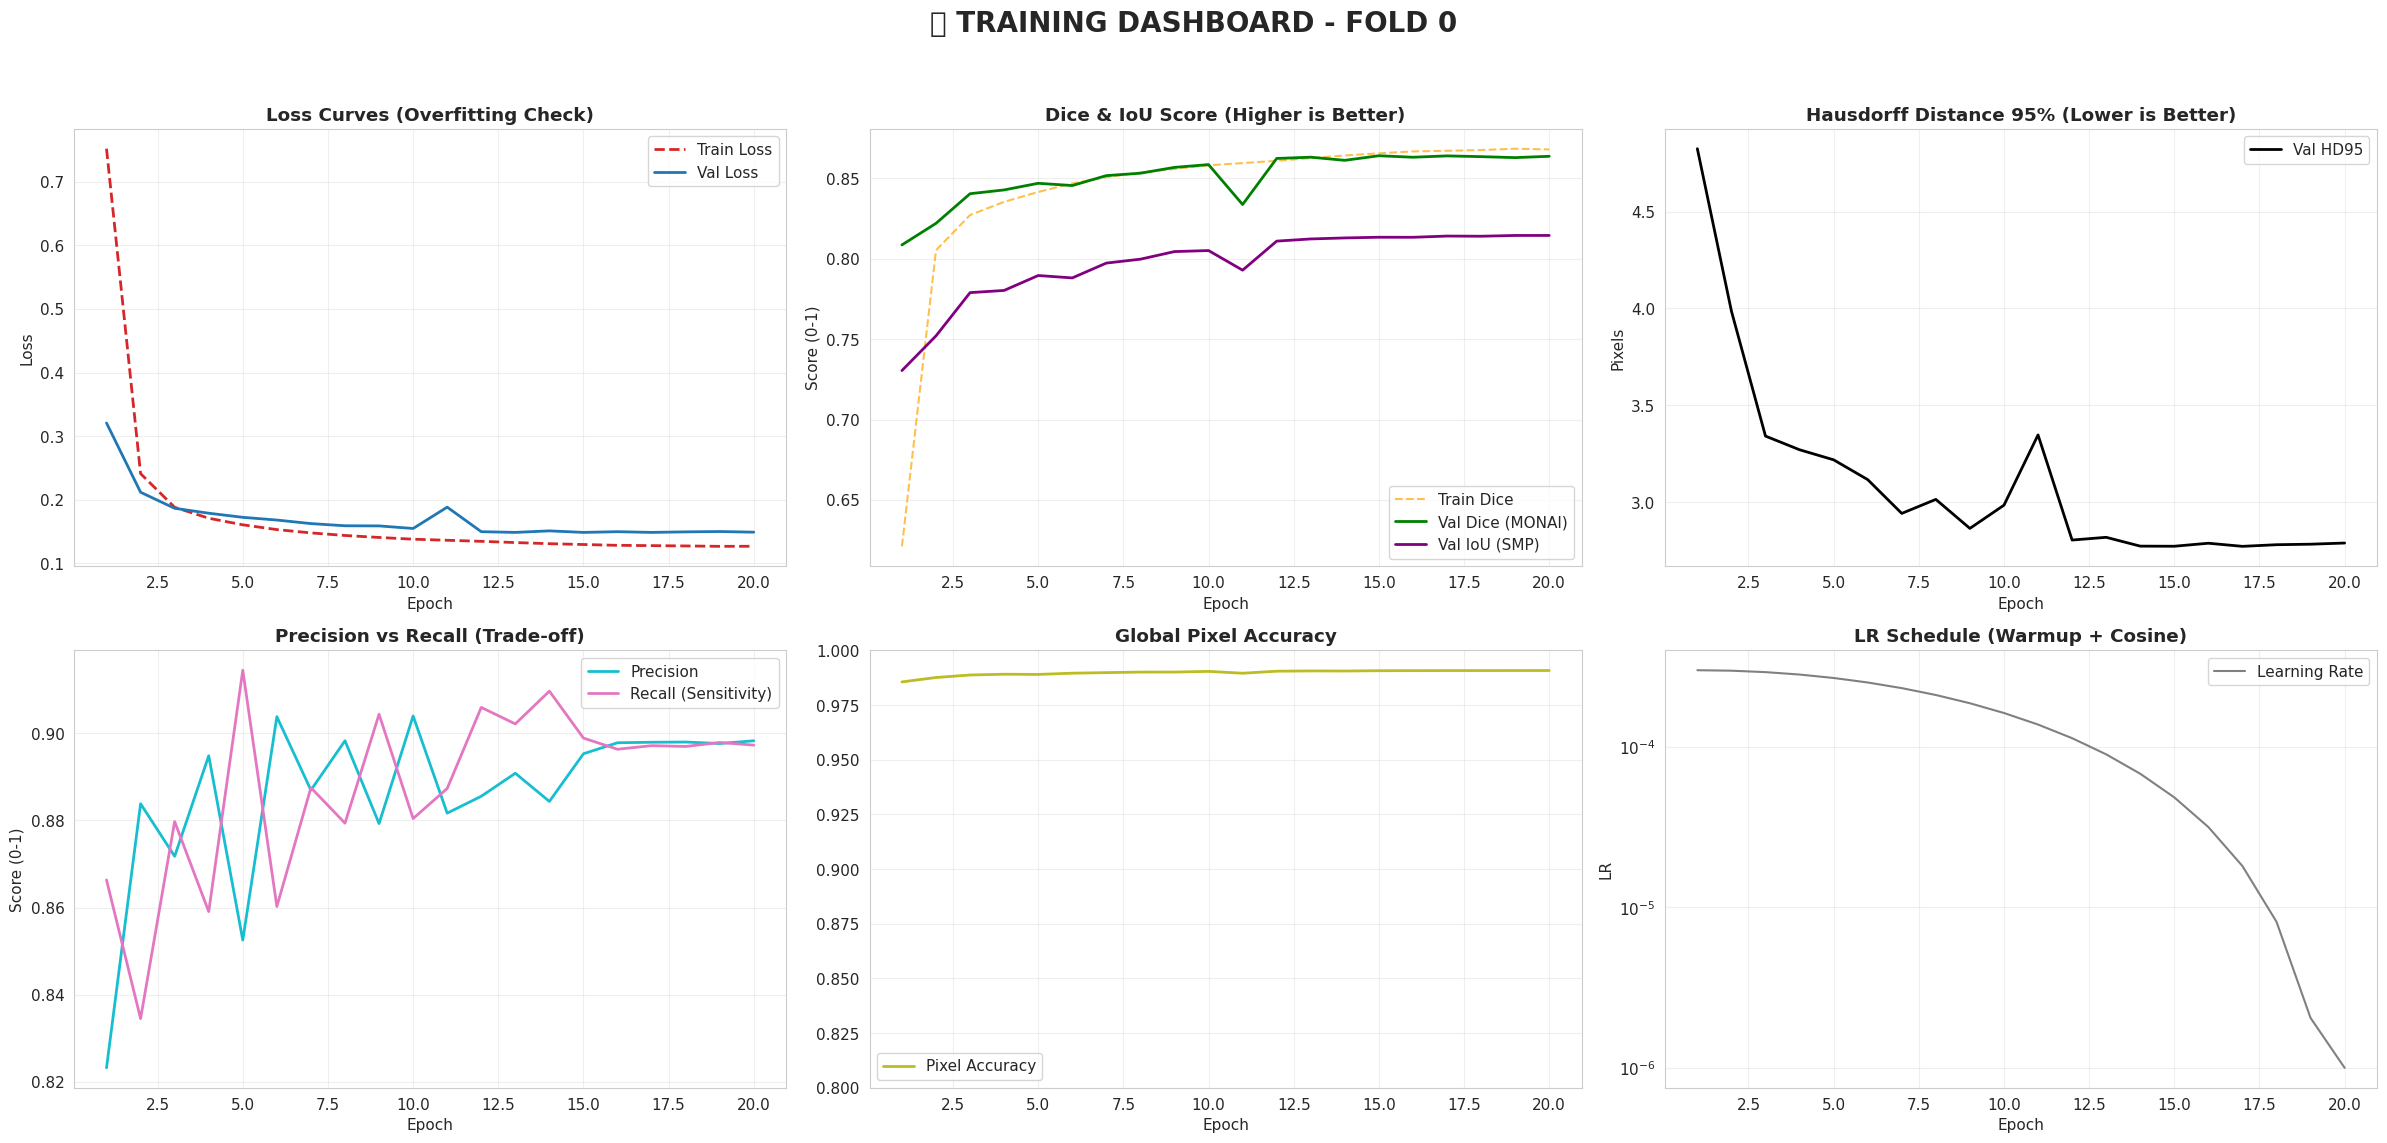

In [8]:
# Cell 8: Comprehensive Metrics Visualization
# ==================================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for nicer plots
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11})

def plot_fold_dashboard(history, fold_idx):
    if not history:
        print(f"⚠️ No history found for Fold {fold_idx}. Skipping.")
        return

    epochs = [x['epoch'] for x in history]
    
    # Extract Metrics
    t_loss = [x['train/loss'] for x in history]
    v_loss = [x['val_loss'] for x in history]
    
    t_dice = [x['train/dice_smp'] for x in history]
    v_dice = [x['val_dice_monai'] for x in history]
    v_iou  = [x['val_iou_smp'] for x in history]
    
    v_hd95 = [x['val_hd95_monai'] for x in history]
    
    v_prec = [x['val_precision_smp'] for x in history]
    v_rec  = [x['val_recall_smp'] for x in history]
    
    v_acc  = [x['val_acc_smp'] for x in history]
    lrs    = [x['lr'] for x in history]

    # Create 2x3 Grid
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    fig.suptitle(f"📊 TRAINING DASHBOARD - FOLD {fold_idx}", fontsize=20, weight='bold')
    
    # --- PLOT 1: LOSS CURVES ---
    ax = axes[0, 0]
    ax.plot(epochs, t_loss, label='Train Loss', color='tab:red', linewidth=2, linestyle='--')
    ax.plot(epochs, v_loss, label='Val Loss', color='tab:blue', linewidth=2)
    ax.set_title("Loss Curves (Overfitting Check)", weight='bold')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # --- PLOT 2: SEGMENTATION PERFORMANCE ---
    ax = axes[0, 1]
    ax.plot(epochs, t_dice, label='Train Dice', color='orange', linestyle='--', alpha=0.7)
    ax.plot(epochs, v_dice, label='Val Dice (MONAI)', color='green', linewidth=2)
    ax.plot(epochs, v_iou, label='Val IoU (SMP)', color='purple', linewidth=2)
    ax.set_title("Dice & IoU Score (Higher is Better)", weight='bold')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Score (0-1)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # --- PLOT 3: HAUSDORFF DISTANCE ---
    ax = axes[0, 2]
    ax.plot(epochs, v_hd95, label='Val HD95', color='black', linewidth=2)
    ax.set_title("Hausdorff Distance 95% (Lower is Better)", weight='bold')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Pixels")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # --- PLOT 4: PRECISION vs RECALL ---
    ax = axes[1, 0]
    ax.plot(epochs, v_prec, label='Precision', color='tab:cyan', linewidth=2)
    ax.plot(epochs, v_rec, label='Recall (Sensitivity)', color='tab:pink', linewidth=2)
    ax.set_title("Precision vs Recall (Trade-off)", weight='bold')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Score (0-1)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # --- PLOT 5: PIXEL ACCURACY ---
    ax = axes[1, 1]
    ax.plot(epochs, v_acc, label='Pixel Accuracy', color='tab:olive', linewidth=2)
    ax.set_title("Global Pixel Accuracy", weight='bold')
    ax.set_xlabel("Epoch")
    ax.set_ylim(0.8, 1.0) # Accuracy is usually high, zoom in
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # --- PLOT 6: LEARNING RATE SCHEDULE ---
    ax = axes[1, 2]
    ax.plot(epochs, lrs, label='Learning Rate', color='gray', linestyle='-')
    ax.set_title("LR Schedule (Warmup + Cosine)", weight='bold')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("LR")
    ax.set_yscale("log") # Log scale helps see the decay
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Iterate over all folds present in history
if len(fold_metrics_history) == 0:
    print("❌ No training history found. Did you run Cell 7?")
else:
    for i, history in enumerate(fold_metrics_history):
        plot_fold_dashboard(history, i)


🧪 EVALUATING ON HOLDOUT TEST SET (10%)
✅ Loaded weights from: best_model_fold0.pth


❄️ Validating:   0%|          | 0/5 [00:00<?, ?it/s]


🏆 FINAL TEST SET RESULTS:
   -----------------------
   🎲 Dice Score:      0.8595
   📏 Hausdorff95:     2.80 px
   ⭕ IoU Score:       0.8000
   🎯 Pixel Accuracy:  0.9905
   🔍 Recall (Sens):   0.8643
   🎯 Precision:       0.9149

✅ RESULT: Excellent Generalization.

🎨 VISUALIZING 5 SAMPLES...


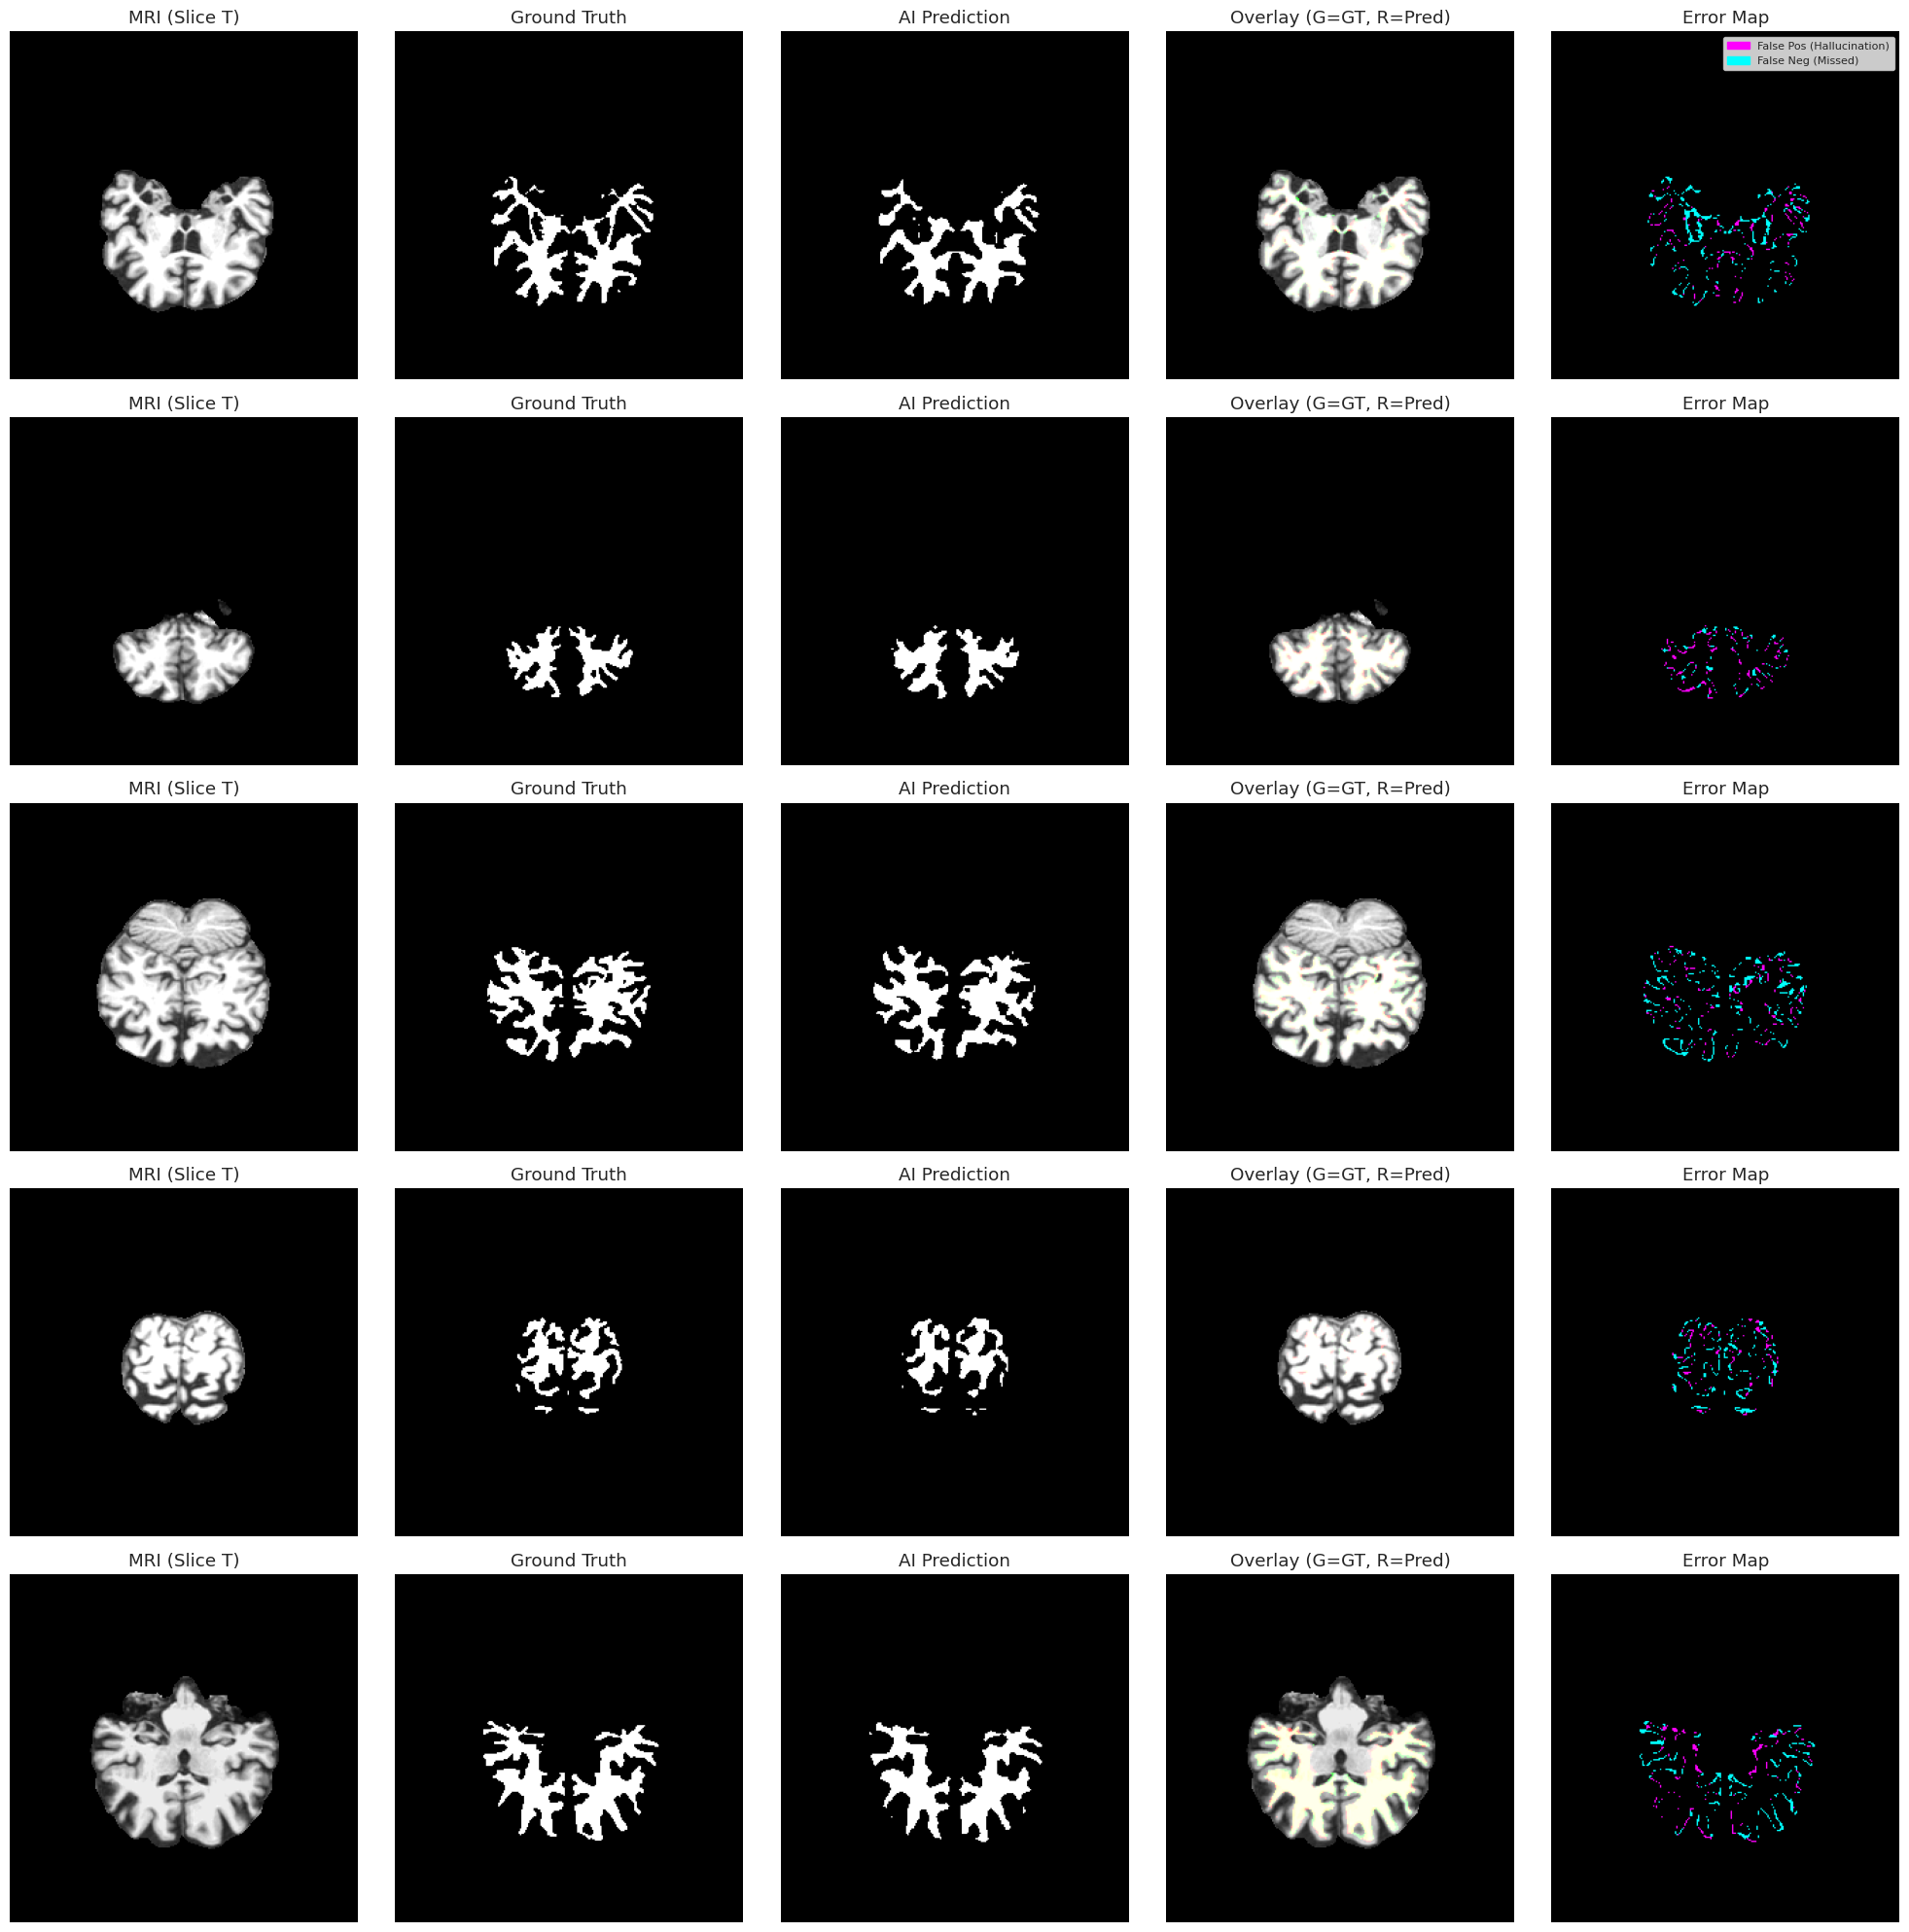

In [13]:
# Cell 9: Holdout Test Evaluation & Error Mapping
# ==================================================================================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def evaluate_test_set(fold=0):
    print("\n" + "="*50)
    print("🧪 EVALUATING ON HOLDOUT TEST SET (10%)")
    print("="*50)
    
    # 1. Load Data
    test_ds = Dataset25D(test_df, transform=get_transforms('valid'))
    test_loader = DataLoader(test_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=4)
    
    # 2. Load Model
    # model = smp.Unet(
    #     encoder_name=CONFIG['ENCODER'],
    #     encoder_weights=None, # Weights loaded from file below
    #     in_channels=CONFIG['IN_CHANNELS'], 
    #     classes=1, 
    #     activation=None
    # ).to(CONFIG['DEVICE'])
    model = smp.DeepLabV3Plus(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=CONFIG['ENCODER_WEIGHTS'],
        in_channels=CONFIG['IN_CHANNELS'], 
        classes=1,
        activation=None,          # We use Logits
        encoder_output_stride=16, # Standard for DeepLab
        upsampling=4,             # Upsamples the output back to original size
        decoder_channels=256,     # Standard width
        decoder_atrous_rates=(12, 24, 36) # Captures multi-scale context
    ).to(CONFIG['DEVICE'])
    
    weights_path = f"best_model_fold{fold}.pth"
    if not os.path.exists(weights_path):
        print(f"❌ Error: Weights file '{weights_path}' not found!")
        return
        
    model.load_state_dict(torch.load(weights_path))
    print(f"✅ Loaded weights from: {weights_path}")
    
    # 3. Calculate Metrics using the Validation Engine
    # We reuse the logic from Cell 6 to ensure consistency
    metrics = valid_one_epoch(model, test_loader, DiceFocalLoss(sigmoid=True))
    
    print("\n🏆 FINAL TEST SET RESULTS:")
    print(f"   -----------------------")
    print(f"   🎲 Dice Score:      {metrics['val_dice_monai']:.4f}")
    print(f"   📏 Hausdorff95:     {metrics['val_hd95_monai']:.2f} px")
    print(f"   ⭕ IoU Score:       {metrics['val_iou_smp']:.4f}")
    print(f"   🎯 Pixel Accuracy:  {metrics['val_acc_smp']:.4f}")
    print(f"   🔍 Recall (Sens):   {metrics['val_recall_smp']:.4f}")
    print(f"   🎯 Precision:       {metrics['val_precision_smp']:.4f}")
    
    if metrics['val_dice_monai'] > 0.85:
        print("\n✅ RESULT: Excellent Generalization.")
    elif metrics['val_dice_monai'] > 0.70:
        print("\n⚠️ RESULT: Good, but room for improvement.")
    else:
        print("\n❌ RESULT: Model is struggling on unseen data.")

def visualize_predictions(fold=0, n_images=5):
    """
    Visualizes Predictions with a dedicated Error Map.
    n_images: How many random samples to show.
    """
    print(f"\n🎨 VISUALIZING {n_images} SAMPLES...")
    
    # Load Model
    model = smp.DeepLabV3Plus(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=CONFIG['ENCODER_WEIGHTS'],
        in_channels=CONFIG['IN_CHANNELS'], 
        classes=1,
        activation=None,          # We use Logits
        encoder_output_stride=16, # Standard for DeepLab
        upsampling=4,             # Upsamples the output back to original size
        decoder_channels=256,     # Standard width
        decoder_atrous_rates=(12, 24, 36) # Captures multi-scale context
    ).to(CONFIG['DEVICE'])
    model.load_state_dict(torch.load(f"best_model_fold{fold}.pth"))
    model.eval()
    
    # Load Loader (Shuffle=True to see random different ones)
    test_ds = Dataset25D(test_df, transform=get_transforms('valid'))
    test_loader = DataLoader(test_ds, batch_size=n_images, shuffle=True)
    
    # Get one batch
    images, masks = next(iter(test_loader))
    images = images.to(CONFIG['DEVICE'])
    
    with torch.no_grad():
        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().cpu()
        
    masks = masks.cpu()
    images = images.cpu()
    
    # Plotting
    fig, axes = plt.subplots(n_images, 5, figsize=(20, 4*n_images))
    if n_images == 1: axes = axes.reshape(1, -1) # Handle single row case
    
    for i in range(n_images):
        # 1. Original Image (Middle Slice)
        # Denormalize simple min-max for view
        img_view = images[i, 1, :, :].numpy()
        img_view = (img_view - img_view.min()) / (img_view.max() - img_view.min() + 1e-6)
        
        axes[i,0].imshow(img_view, cmap='gray')
        axes[i,0].set_title("MRI (Slice T)")
        axes[i,0].axis('off')
        
        # 2. Ground Truth
        axes[i,1].imshow(masks[i,0], cmap='gray')
        axes[i,1].set_title("Ground Truth")
        axes[i,1].axis('off')
        
        # 3. Prediction
        axes[i,2].imshow(preds[i,0], cmap='gray')
        axes[i,2].set_title("AI Prediction")
        axes[i,2].axis('off')
        
        # 4. Overlay (Green=GT, Red=Pred)
        rgb = np.stack([img_view]*3, axis=-1)
        gt_mask = masks[i,0].numpy() > 0.5
        pr_mask = preds[i,0].numpy() > 0.5
        
        # Green channel for GT, Red channel for Pred
        # Yellow will appear where they overlap (R+G)
        rgb[gt_mask, 1] = 1.0 
        rgb[pr_mask, 0] = 1.0 
        
        axes[i,3].imshow(rgb)
        axes[i,3].set_title("Overlay (G=GT, R=Pred)")
        axes[i,3].axis('off')
        
        # 5. ERROR MAP (New)
        # FP = Predicted 1 but GT 0 (Hallucination) -> Magenta
        # FN = Predicted 0 but GT 1 (Missed) -> Cyan
        fp = (pr_mask == 1) & (gt_mask == 0)
        fn = (pr_mask == 0) & (gt_mask == 1)
        
        error_map = np.zeros_like(rgb)
        error_map[fp] = [1, 0, 1] # Magenta
        error_map[fn] = [0, 1, 1] # Cyan
        
        # Add legend patches
        patches = [
            mpatches.Patch(color='magenta', label='False Pos (Hallucination)'),
            mpatches.Patch(color='cyan', label='False Neg (Missed)')
        ]
        
        axes[i,4].imshow(error_map)
        axes[i,4].set_title("Error Map")
        axes[i,4].axis('off')
        if i == 0: axes[i,4].legend(handles=patches, loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
evaluate_test_set(fold=0)
visualize_predictions(fold=0, n_images=5) # Change n_images to 10 or 20 to see more

🕵️ RUNNING DEEP FAILURE ANALYSIS...
   -> Scanning 613 test images (this may take a minute)...


  0%|          | 0/613 [00:00<?, ?it/s]

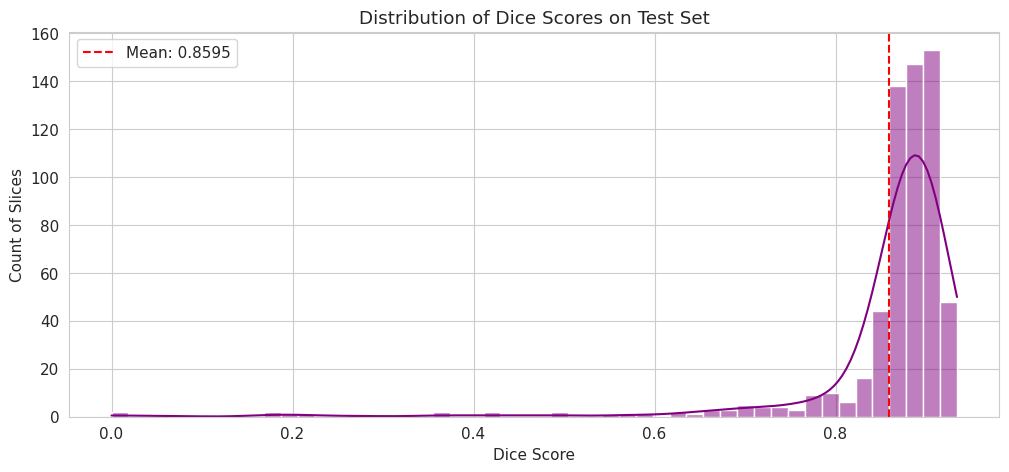


📉 TOP 5 WORST FAILURES:


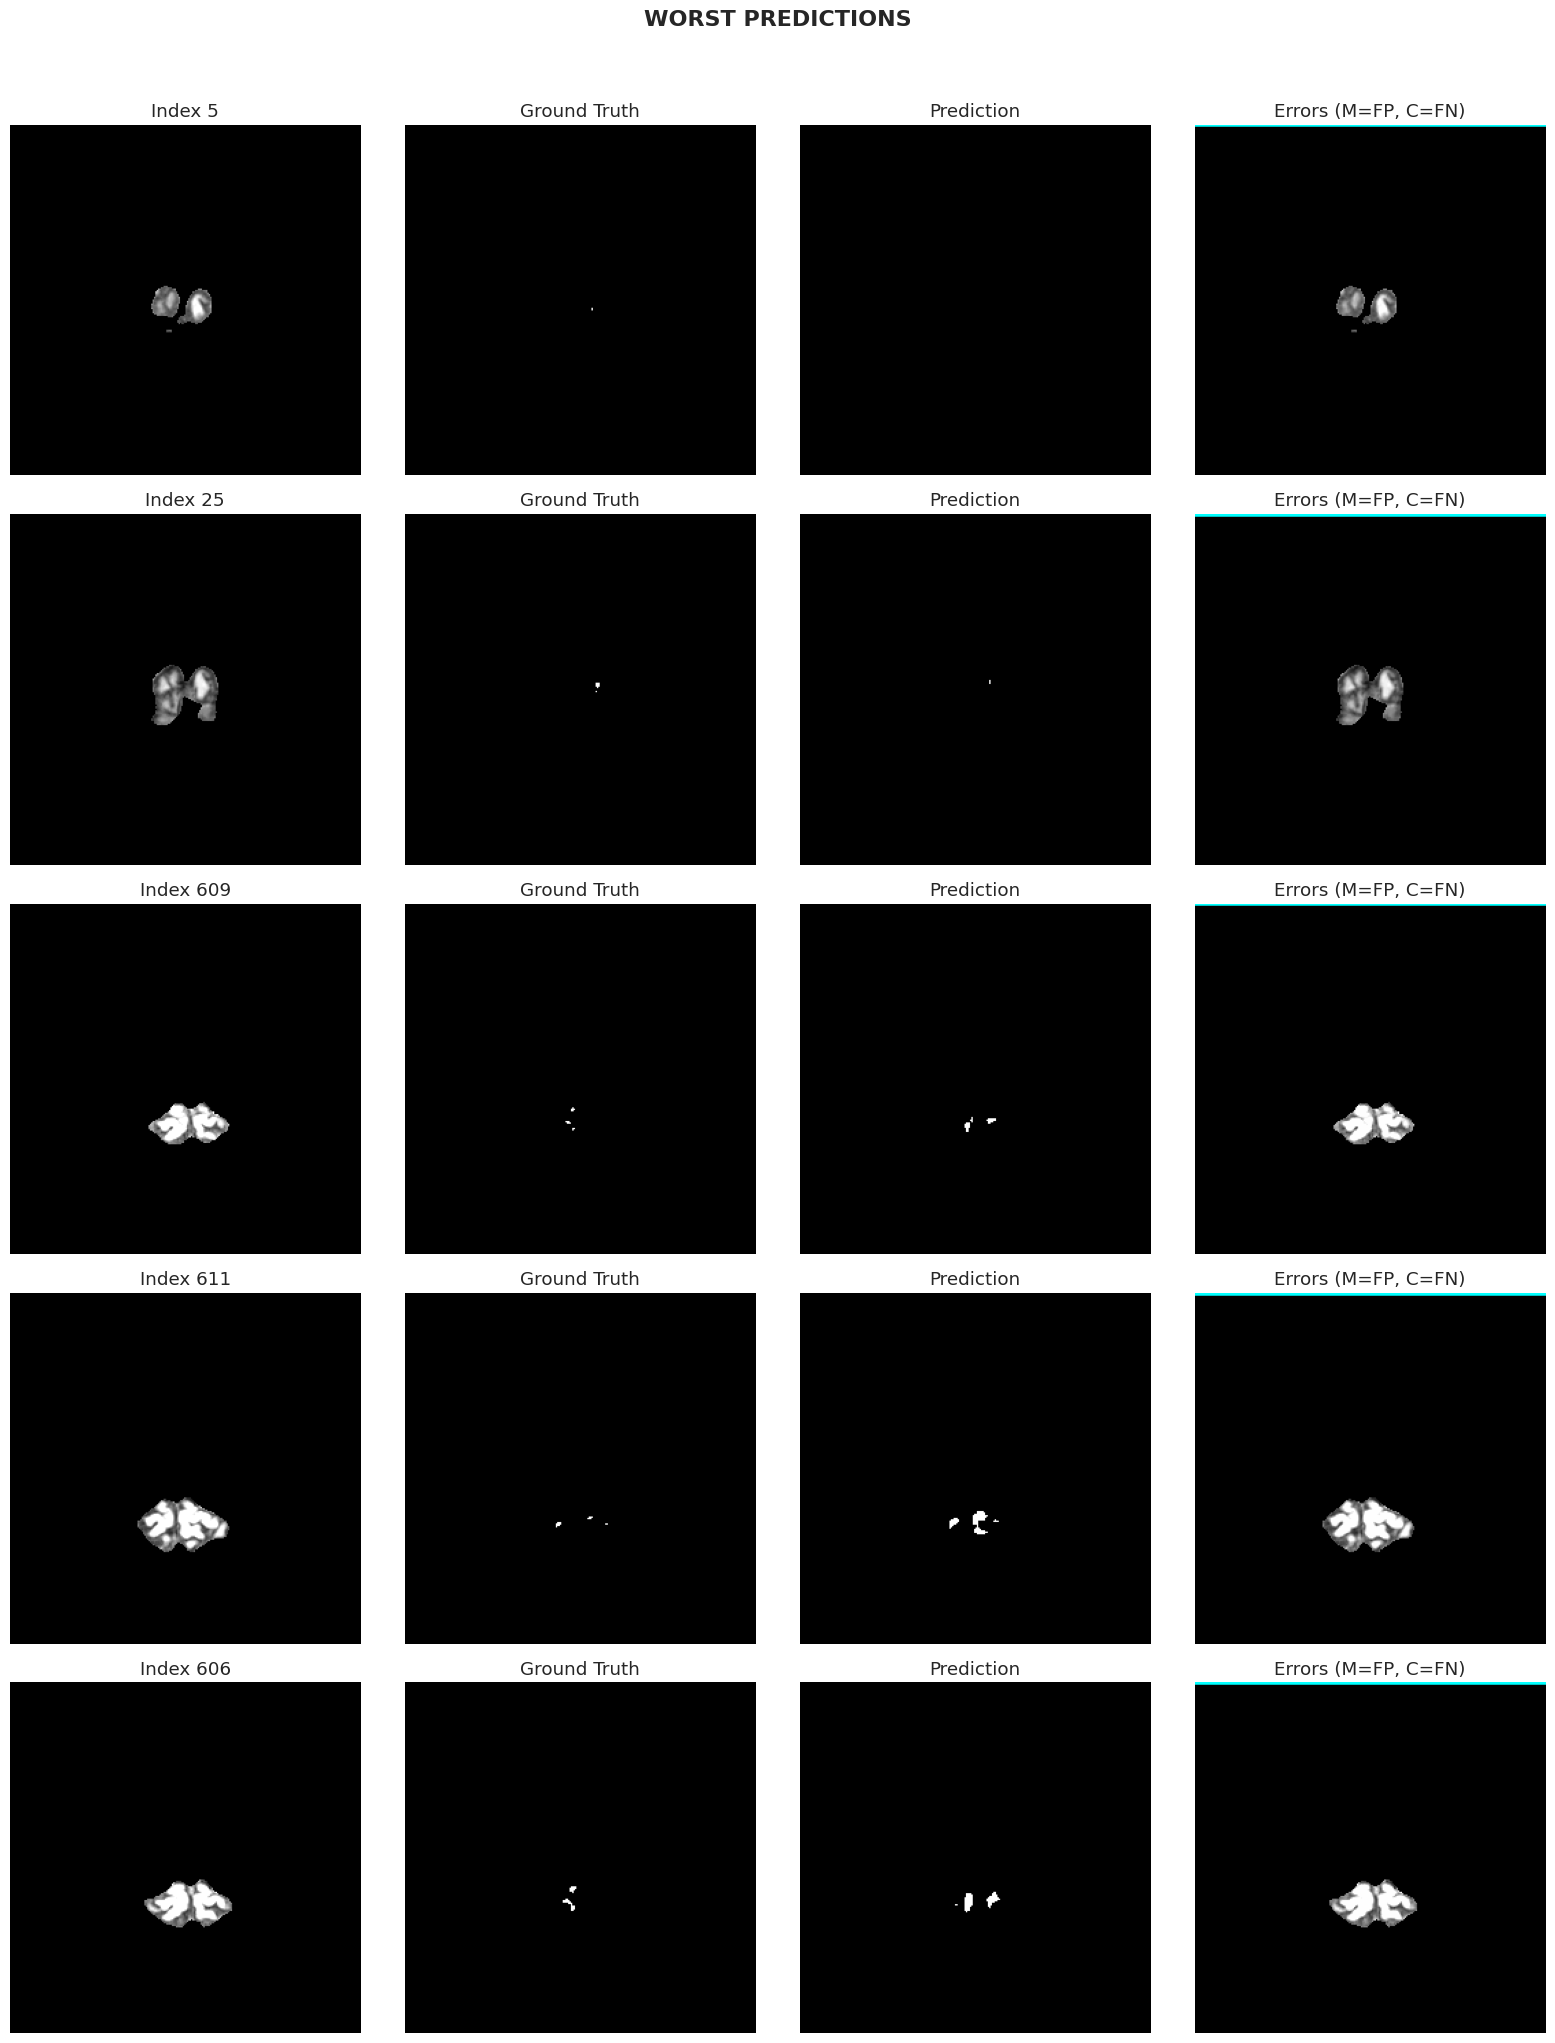


🏆 TOP 5 BEST SUCCESSES:


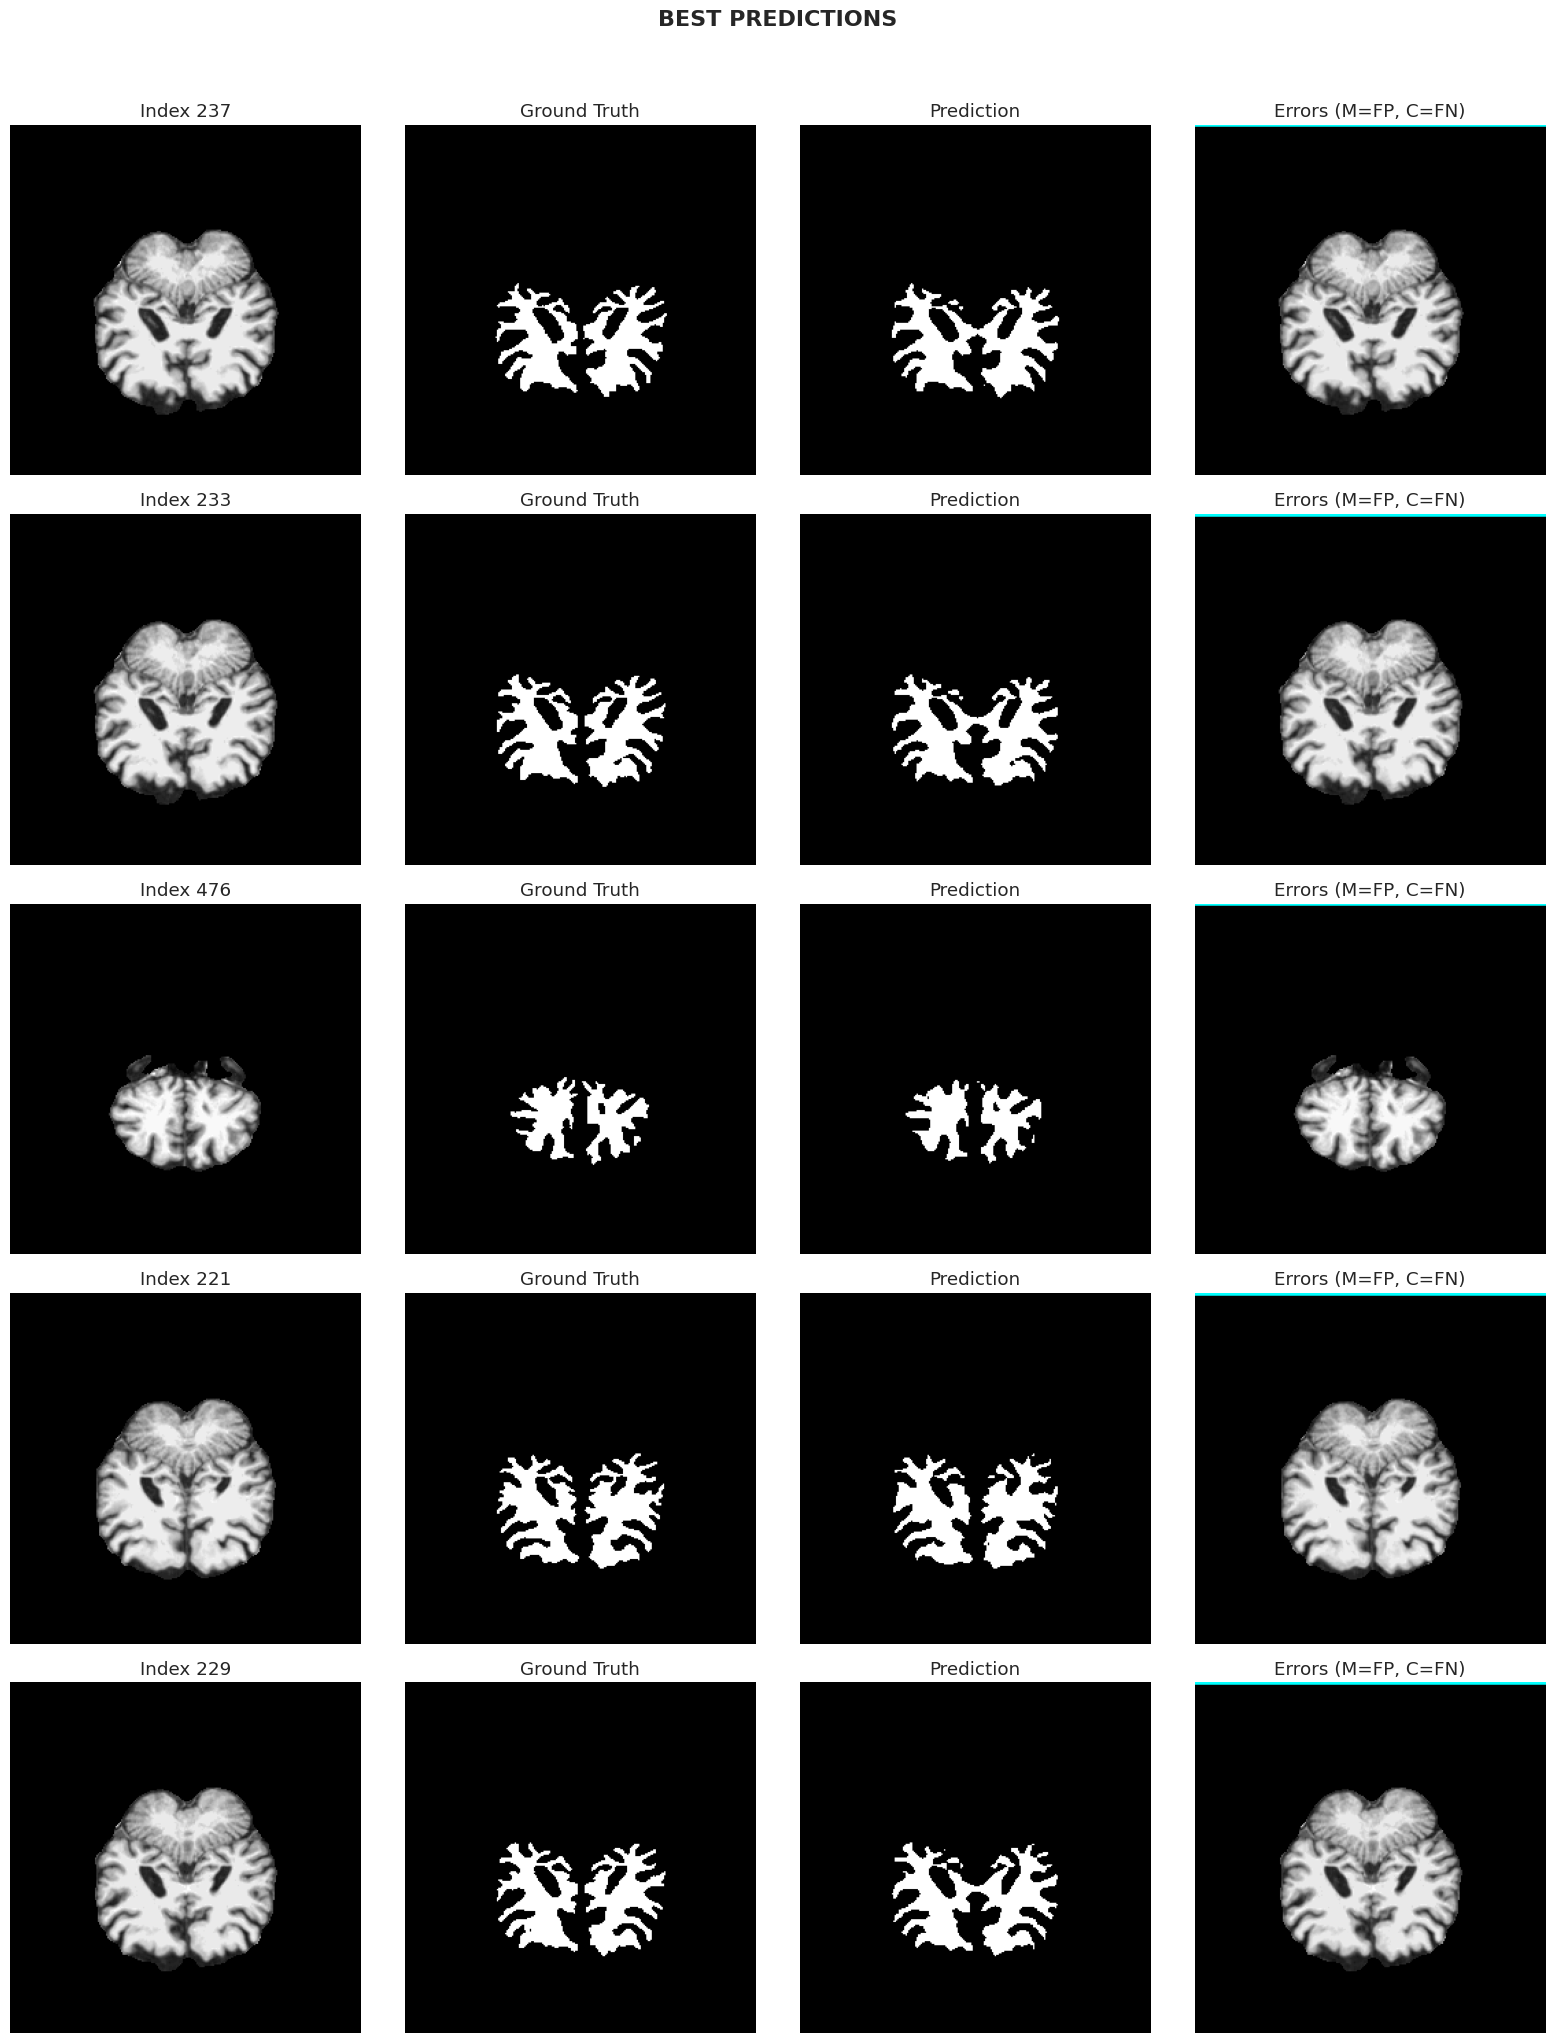

In [14]:
# Cell 10: Failure Analysis & Score Distribution
# ==================================================================================
import pandas as pd
import seaborn as sns

def analyze_failures(fold=0):
    print("🕵️ RUNNING DEEP FAILURE ANALYSIS...")
    
    # 1. Setup
    # model = smp.Unet(encoder_name=CONFIG['ENCODER'], in_channels=3, classes=1, activation=None).to(CONFIG['DEVICE'])
    model = smp.DeepLabV3Plus(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=CONFIG['ENCODER_WEIGHTS'],
        in_channels=CONFIG['IN_CHANNELS'], 
        classes=1,
        activation=None,          # We use Logits
        encoder_output_stride=16, # Standard for DeepLab
        upsampling=4,             # Upsamples the output back to original size
        decoder_channels=256,     # Standard width
        decoder_atrous_rates=(12, 24, 36) # Captures multi-scale context
    ).to(CONFIG['DEVICE'])
    model.load_state_dict(torch.load(f"best_model_fold{fold}.pth"))
    model.eval()
    
    ds = Dataset25D(test_df, transform=get_transforms('valid'))
    # Batch size 1 is slower but easier to track individual indices without complex mapping
    loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=4)
    
    results = []
    
    print(f"   -> Scanning {len(ds)} test images (this may take a minute)...")
    
    # 2. Inference Loop
    with torch.no_grad():
        for idx, (img, mask) in enumerate(tqdm(loader, leave=False)):
            img = img.to(CONFIG['DEVICE'])
            mask = mask.to(CONFIG['DEVICE'])
            
            logits = model(img)
            pred = (torch.sigmoid(logits) > 0.5).float()
            
            # Calc Dice for this specific image
            # We use 'micro' on single image == basic Dice
            tp, fp, fn, tn = smp_metrics.get_stats(pred.long(), mask.long(), mode='binary', threshold=0.5)
            dice = smp_metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise").item()
            
            # Check if mask was empty (for analysis context)
            is_empty_mask = mask.sum().item() == 0
            
            results.append({
                "idx": idx,
                "dice": dice,
                "is_empty": is_empty_mask
            })
            
    # 3. Create DataFrame
    res_df = pd.DataFrame(results)
    
    # 4. Plot Histogram
    plt.figure(figsize=(12, 5))
    sns.histplot(data=res_df, x='dice', bins=50, kde=True, color='purple')
    plt.title("Distribution of Dice Scores on Test Set")
    plt.xlabel("Dice Score")
    plt.ylabel("Count of Slices")
    plt.axvline(res_df['dice'].mean(), color='red', linestyle='--', label=f"Mean: {res_df['dice'].mean():.4f}")
    plt.legend()
    plt.show()
    
    # 5. Extract Worst and Best
    # We ignore empty masks for "Worst" ranking if Dice is 1.0 (Correctly predicted empty)
    # We focus on cases where Dice < 1.0
    failures = res_df.sort_values(by='dice', ascending=True).head(5)
    successes = res_df.sort_values(by='dice', ascending=False).head(5)
    
    print("\n📉 TOP 5 WORST FAILURES:")
    plot_gallery(ds, model, failures['idx'].values, title="WORST PREDICTIONS")
    
    print("\n🏆 TOP 5 BEST SUCCESSES:")
    plot_gallery(ds, model, successes['idx'].values, title="BEST PREDICTIONS")

def plot_gallery(dataset, model, indices, title="Gallery"):
    fig, axes = plt.subplots(len(indices), 4, figsize=(16, 4*len(indices)))
    fig.suptitle(title, fontsize=16, weight='bold', y=1.02)
    
    for row, idx in enumerate(indices):
        # Load single item
        img_stack, mask = dataset[idx]
        img_tensor = img_stack.unsqueeze(0).to(CONFIG['DEVICE']) # Add batch dim
        
        # Infer
        with torch.no_grad():
            logits = model(img_tensor)
            pred = (torch.sigmoid(logits) > 0.5).float().cpu()[0, 0]
            
        # Prep for display
        img = img_stack[1, :, :].numpy() # Middle slice
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        mask = mask[0].numpy()
        
        # 1. MRI
        axes[row, 0].imshow(img, cmap='gray')
        axes[row, 0].set_title(f"Index {idx}")
        axes[row, 0].axis('off')
        
        # 2. GT
        axes[row, 1].imshow(mask, cmap='gray')
        axes[row, 1].set_title("Ground Truth")
        axes[row, 1].axis('off')
        
        # 3. Pred
        axes[row, 2].imshow(pred, cmap='gray')
        axes[row, 2].set_title("Prediction")
        axes[row, 2].axis('off')
        
        # 4. Error Map
        # FP=Magenta, FN=Cyan
        rgb = np.stack([img]*3, axis=-1)
        fp = (pred == 1) & (mask == 0)
        fn = (pred == 0) & (mask == 1)
        rgb[fp] = [1, 0, 1] 
        rgb[fn] = [0, 1, 1]
        
        axes[row, 3].imshow(rgb)
        axes[row, 3].set_title("Errors (M=FP, C=FN)")
        axes[row, 3].axis('off')
        
    plt.tight_layout()
    plt.show()

# Run it
analyze_failures(fold=0)

🌍 PREPARING INDEPENDENT EXTERNAL TEST SET...
   -> Loaded 1588 rows from external CSV.
   -> 2.5D Context generated successfully.
   -> Loading Model Architecture: resnet50
   -> Loading Weights from: /kaggle/working/best_model_fold0.pth


❄️ Validating:   0%|          | 0/13 [00:00<?, ?it/s]


🏆 FINAL EXTERNAL TEST SET RESULTS:
   -----------------------
   🎲 Dice Score:      0.8450
   📏 Hausdorff95:     2.91 px
   ⭕ IoU Score:       0.8029
   🎯 Pixel Accuracy:  0.9916
   🔍 Recall (Sens):   0.9143
   🎯 Precision:       0.8682

⚠️ RESULT: Good, but room for improvement.

🎨 VISUALIZING 5 EXTERNAL SAMPLES...


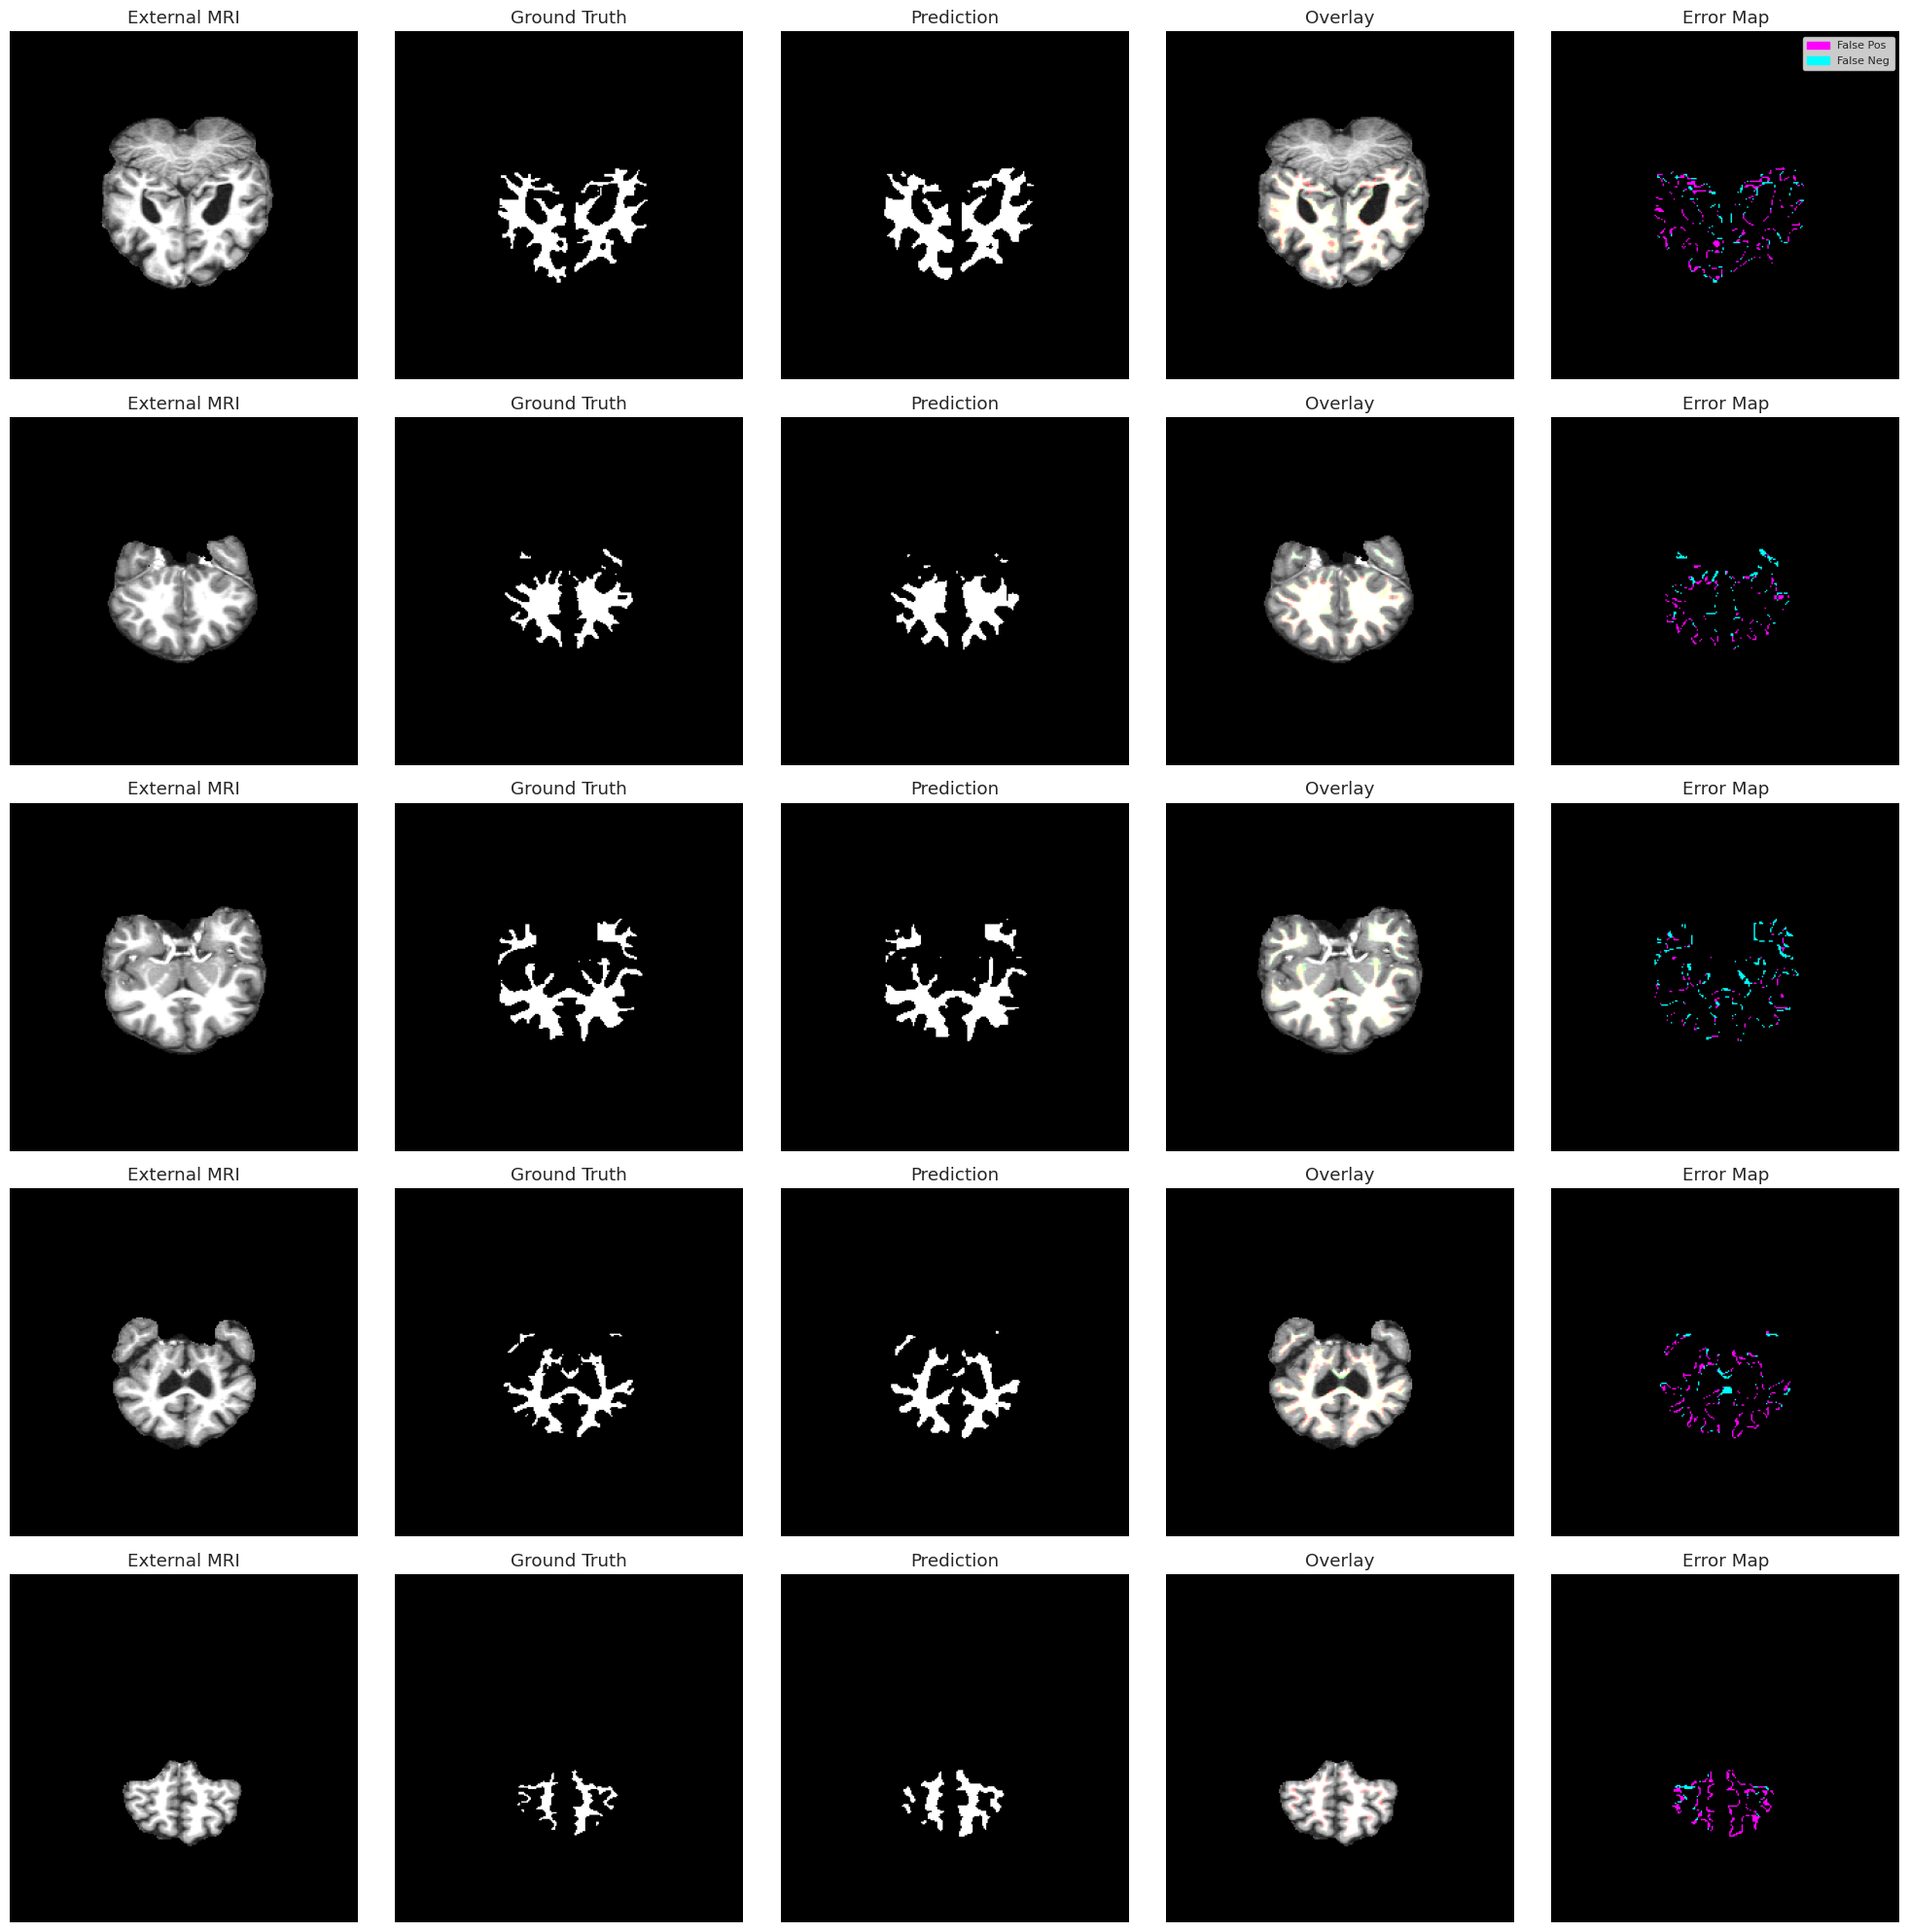

In [15]:
# Cell 12: Independent External Dataset Evaluation
# ==================================================================================
import os
import pandas as pd
import re
import matplotlib.patches as mpatches
from torch.utils.data import DataLoader

# ------------------------------------------------------------------
# 1. CONFIGURATION FOR EXTERNAL DATA
# ⚠️ UPDATE THESE PATHS ⚠️
# ------------------------------------------------------------------
EXTERNAL_CONFIG = {
    # Path to the NEW dataset CSV
    "CSV_PATH": "/kaggle/input/oasis-freesurfer-processed-for-evaluation/PROCESSED_DATASET_OASIS/metadata.csv",  
    
    # Path to the folder containing 'images' and 'masks' subfolders
    "DATA_ROOT": "/kaggle/input/oasis-freesurfer-processed-for-evaluation/PROCESSED_DATASET_OASIS",             
    
    # Path to your TRAINED MODEL weights
    "MODEL_PATH": "/kaggle/working/best_model_fold0.pth",       
    
    "BATCH_SIZE": CONFIG['BATCH_SIZE']
}

print("🌍 PREPARING INDEPENDENT EXTERNAL TEST SET...")

# ------------------------------------------------------------------
# 2. ADAPTIVE DATASET CLASS
# ------------------------------------------------------------------
class ExternalDataset25D(Dataset25D):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')

# ------------------------------------------------------------------
# 3. PREPARE EXTERNAL DATAFRAME
# ------------------------------------------------------------------
def prepare_external_data(csv_path):
    if not os.path.exists(csv_path):
        print(f"❌ Error: External CSV not found at {csv_path}")
        return None
        
    df = pd.read_csv(csv_path)
    print(f"   -> Loaded {len(df)} rows from external CSV.")
    
    required_cols = ['patient', 'image_id', 'mask_id']
    if not all(col in df.columns for col in required_cols):
        print(f"❌ Error: CSV missing one of {required_cols}")
        return None

    def extract_slice(x):
        match = re.search(r'slice_(\d+)', x)
        return int(match.group(1)) if match else 0
    df['slice_num'] = df['image_id'].apply(extract_slice)
    
    # Sort & 2.5D Shift
    df = df.sort_values(by=['patient', 'slice_num']).reset_index(drop=True)
    df['prev_image_id'] = df.groupby('patient')['image_id'].shift(1)
    df['next_image_id'] = df.groupby('patient')['image_id'].shift(-1)
    df['prev_image_id'] = df['prev_image_id'].fillna(df['image_id'])
    df['next_image_id'] = df['next_image_id'].fillna(df['image_id'])
    
    print("   -> 2.5D Context generated successfully.")
    return df

# ------------------------------------------------------------------
# 4. RUN EVALUATION (With Full Report)
# ------------------------------------------------------------------
def evaluate_external_set(model_weights_path):
    # Prepare Data
    ext_df = prepare_external_data(EXTERNAL_CONFIG['CSV_PATH'])
    if ext_df is None: return
    
    # Create Dataset
    ext_ds = ExternalDataset25D(ext_df, root_dir=EXTERNAL_CONFIG['DATA_ROOT'], transform=get_transforms('valid'))
    ext_loader = DataLoader(ext_ds, batch_size=EXTERNAL_CONFIG['BATCH_SIZE'], shuffle=False, num_workers=4)
    
    # Load Model Architecture
    print(f"   -> Loading Model Architecture: {CONFIG['ENCODER']}")
    # model = smp.Unet(
    #     encoder_name=CONFIG['ENCODER'],
    #     encoder_weights=None,
    #     in_channels=CONFIG['IN_CHANNELS'],
    #     classes=1,
    #     activation=None
    # ).to(CONFIG['DEVICE'])    
    model = smp.DeepLabV3Plus(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=CONFIG['ENCODER_WEIGHTS'],
        in_channels=CONFIG['IN_CHANNELS'], 
        classes=1,
        activation=None,          # We use Logits
        encoder_output_stride=16, # Standard for DeepLab
        upsampling=4,             # Upsamples the output back to original size
        decoder_channels=256,     # Standard width
        decoder_atrous_rates=(12, 24, 36) # Captures multi-scale context
    ).to(CONFIG['DEVICE'])
    
    # Load Weights
    if not os.path.exists(model_weights_path):
        print(f"❌ Error: Weights file not found at {model_weights_path}")
        return

    print(f"   -> Loading Weights from: {model_weights_path}")
    state_dict = torch.load(model_weights_path, map_location=CONFIG['DEVICE'])
    
    # Handle DataParallel 'module.' prefix if needed
    if list(state_dict.keys())[0].startswith('module.'):
        state_dict = {k[7:]: v for k, v in state_dict.items()}
        
    model.load_state_dict(state_dict)
    
    # Run Metrics
    metrics = valid_one_epoch(model, ext_loader, DiceFocalLoss(sigmoid=True))
    
    # --- 📄 GENERATE REPORT 📄 ---
    print("\n🏆 FINAL EXTERNAL TEST SET RESULTS:")
    print(f"   -----------------------")
    print(f"   🎲 Dice Score:      {metrics['val_dice_monai']:.4f}")
    print(f"   📏 Hausdorff95:     {metrics['val_hd95_monai']:.2f} px")
    print(f"   ⭕ IoU Score:       {metrics['val_iou_smp']:.4f}")
    print(f"   🎯 Pixel Accuracy:  {metrics['val_acc_smp']:.4f}")
    print(f"   🔍 Recall (Sens):   {metrics['val_recall_smp']:.4f}")
    print(f"   🎯 Precision:       {metrics['val_precision_smp']:.4f}")
    
    if metrics['val_dice_monai'] > 0.85:
        print("\n✅ RESULT: Excellent Generalization.")
    elif metrics['val_dice_monai'] > 0.70:
        print("\n⚠️ RESULT: Good, but room for improvement.")
    else:
        print("\n❌ RESULT: Model is struggling on unseen data.")

    # Visualizations
    visualize_external_predictions(model, ext_ds)

def visualize_external_predictions(model, dataset, n_images=5):
    print(f"\n🎨 VISUALIZING {n_images} EXTERNAL SAMPLES...")
    viz_loader = DataLoader(dataset, batch_size=n_images, shuffle=True)
    images, masks = next(iter(viz_loader))
    images = images.to(CONFIG['DEVICE'])
    
    model.eval()
    with torch.no_grad():
        logits = model(images)
        preds = (torch.sigmoid(logits) > 0.5).float().cpu()
        
    masks = masks.cpu()
    images = images.cpu()
    
    fig, axes = plt.subplots(n_images, 5, figsize=(20, 4*n_images))
    if n_images == 1: axes = axes.reshape(1, -1)
    
    for i in range(n_images):
        # Image
        img_view = images[i, 1, :, :].numpy()
        img_view = (img_view - img_view.min()) / (img_view.max() - img_view.min() + 1e-6)
        axes[i,0].imshow(img_view, cmap='gray')
        axes[i,0].set_title("External MRI")
        axes[i,0].axis('off')
        
        # GT
        axes[i,1].imshow(masks[i,0], cmap='gray')
        axes[i,1].set_title("Ground Truth")
        axes[i,1].axis('off')
        
        # Pred
        axes[i,2].imshow(preds[i,0], cmap='gray')
        axes[i,2].set_title("Prediction")
        axes[i,2].axis('off')
        
        # Overlay
        rgb = np.stack([img_view]*3, axis=-1)
        gt_mask = masks[i,0].numpy() > 0.5
        pr_mask = preds[i,0].numpy() > 0.5
        rgb[gt_mask, 1] = 1.0 
        rgb[pr_mask, 0] = 1.0 
        axes[i,3].imshow(rgb)
        axes[i,3].set_title("Overlay")
        axes[i,3].axis('off')
        
        # Error Map
        fp = (pr_mask == 1) & (gt_mask == 0)
        fn = (pr_mask == 0) & (gt_mask == 1)
        error_map = np.zeros_like(rgb)
        error_map[fp] = [1, 0, 1] # Magenta
        error_map[fn] = [0, 1, 1] # Cyan
        axes[i,4].imshow(error_map)
        axes[i,4].set_title("Error Map")
        axes[i,4].axis('off')
        
        # Add Legend to first plot
        if i == 0:
            patches = [
                mpatches.Patch(color='magenta', label='False Pos'),
                mpatches.Patch(color='cyan', label='False Neg')
            ]
            axes[i,4].legend(handles=patches, loc='upper right', fontsize=8)
        
    plt.tight_layout()
    plt.show()

# Run it
evaluate_external_set(EXTERNAL_CONFIG['MODEL_PATH'])

In [16]:
# Cell 11: Inference Helper (Use this for new files)
# ==================================================================================
def predict_single_case(prev_path, curr_path, next_path):
    """
    Predicts a mask for a single 2.5D slice tuple.
    Handles loading, preprocessing, inference, and resizing back to original.
    """
    # 1. Load & Stack
    paths = [prev_path, curr_path, next_path]
    images = []
    for p in paths:
        if os.path.exists(p):
            i = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        else:
            i = np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), dtype=np.uint8)
        images.append(i)
        
    stack = np.stack(images, axis=-1)
    
    # 2. Preprocess (Same as training!)
    # Resize
    h, w = stack.shape[:2]
    aug = A.Compose([A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])])
    stack = aug(image=stack)['image']
    
    # Percentile Norm
    stack = percentile_preprocess(stack)
    
    # To Tensor
    stack = np.transpose(stack, (2, 0, 1))
    stack = torch.from_numpy(stack).float().unsqueeze(0).to(CONFIG['DEVICE'])
    
    # 3. Model Inference
    model.eval()
    with torch.no_grad():
        logits = model(stack)
        probs = torch.sigmoid(logits)
        pred = (probs > 0.5).float()
        
    # 4. Resize back to original
    pred = pred.cpu().numpy()[0, 0]
    pred = cv2.resize(pred, (w, h), interpolation=cv2.INTER_NEAREST)
    
    return pred

print("✅ Inference Helper defined. Usage:")
print("mask = predict_single_case('slice_09.png', 'slice_10.png', 'slice_11.png')")
print("plt.imshow(mask)")

✅ Inference Helper defined. Usage:
mask = predict_single_case('slice_09.png', 'slice_10.png', 'slice_11.png')
plt.imshow(mask)
